# Expert system to assess precarity

This notebook serves as a comprehensive set of guidelines for an expert system to assess precarity, explaining our methodology and offering clear instructions for implementation. A novel approach is introduced, integrating statistical analysis of nine indicators associated with precarity, with a rule-based expert system to assess the precarity level of individual workers. The suggested method can be implemented with slight adjustments for similar problems.



##Data Uploading

We begin by uploading necessary files in MyDrive and gaining access to the user’s Google Drive within the Colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
path="/content/drive/My Drive/"

Mounted at /content/drive


The provided code reads a .csv file into a pandas DataFrame, fills any missing values with -1 and creates a new column named ‘row_id’ with unique identifiers for each row. We display the data as shown below.

In [ ]:
import pandas as pd

data = pd.read_csv(path + "ESS9e03_1.csv", sep=None)

data.fillna(-1, inplace=True)
data['row_id'] = range(0, len(data))

data.head()

<ipython-input-2-bcd4b886f893>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(path + "ESS9e03_1.csv", sep=None)


,﻿name,essround,edition,proddate,idno,Country,nwspol,netusoft,netustm,ppltrst,...,inwtm,dweight,pspwght,pweight,anweight,domain,prob,stratum,psu,row_id
0,ESS9e03_1,9,3.1,17.02.2021,27,AT,60,5,180,2,...,46,"0,58","0,22","0,30","0,07",2,"0,001175548532",59,1688,0
1,ESS9e03_1,9,3.1,17.02.2021,137,AT,10,5,20,7,...,73,"1,06","0,41","0,30","0,12",2,"0,000642845640",79,88,1
2,ESS9e03_1,9,3.1,17.02.2021,194,AT,60,4,180,5,...,92,"1,38","2,27","0,30","0,69",2,"0,000496327179",11,938,2
3,ESS9e03_1,9,3.1,17.02.2021,208,AT,45,5,120,3,...,134,"0,99","0,39","0,30","0,12",2,"0,000687738182",74,1998,3
4,ESS9e03_1,9,3.1,17.02.2021,220,AT,30,1,6666,5,...,40,"0,38","1,03","0,30","0,31",2,"0,001810500864",99,601,4


We include a subset of columns that are relevant to the problem in hand ("row_id", "HoursWorked", "EmploymentContract", "SetHours", "HouseholdsIncome", and "netilet"). Those will be our indicators. We then extract rows that correspond to employees (rows with ’EmploymentRelation’==1).

In [ ]:
indicators = ["row_id", "HoursWorked", "EmploymentContract", "SetHours", "HouseholdsIncome", "netilet"]
data1 = pd.DataFrame()
data1 = data.loc[data['EmploymentRelation'] == 1]
data1 = data1[indicators]
data1.head()

,row_id,HoursWorked,EmploymentContract,SetHours,HouseholdsIncome,netilet
0,0,0,1,1,3,66
1,1,40,1,1,5,66
2,2,40,1,1,9,66
5,5,40,1,1,5,66
6,6,40,1,1,7,66


We convert our data into a NumPy array using the to_numpy() method, as shown below.

In [ ]:
data1 = data1.to_numpy()

## Objective Precariousness Rate

We calculate each employee’s precariousness rate by taking the sum of indicator ratings for each of the three domains (Insecure employment, Unsupportive entitlement, and Insufficient resources). For example, ScoreIE (Insecure Employment score) corresponds to the sum of Part-time employment (PT) indicator score (from 0 to 35), Temporary employment (TE) indicator score (from 0 to 35) and Fixed working hours (FH) indicator score (from 0 to 30). We obtain the three scores ranging from 0 to 100 (ScoreIE, ScoreUE, and ScoreIR) corresponding respectively to the three domains (Insecure employment, Unsupportive entitlement, and Insufficient resources). Each domain score contributes to a single weight, and the three weights (w1,w2,w3) are multiplied to determine the overall precariousness rate for each individual.





In [ ]:
precariousness_rate = []

for row in range(len(data1)):
  ScoreIE = 0
  if data1[row][1] != "#ΚΕΝΟ!":
    if int(data1[row][1]) <= 30:
      ScoreIE = ScoreIE + 35
  if data1[row][2] == 2 or data1[row][2] == 3:
    ScoreIE = ScoreIE + 35
  if data1[row][3] == 2:
    ScoreIE = ScoreIE + 30
  ScoreUE = 0
  if data1[row][2] == 3:
    ScoreUE = ScoreUE + 100
  ScoreIR = 0
  if data1[row][4] <= 3:
    ScoreIR = ScoreIR + 40
  if data1[row][5] <= 3:
    ScoreIR = ScoreIR + 60

  w1 = 1 + ScoreIE/100
  w2 = 1 + ScoreUE/100
  w3 = 1 + ScoreIR/100
  score = (w1*w2*w3 - 1) * 100 / 7
  precariousness_rate.append((int(data1[row][0]), int(score)))

print("Precariousness Rate Tuples:")
print(precariousness_rate[0:40])

values = []
for item in precariousness_rate:
  if item[1] not in values:
    values.append(item[1])

values_sorted = values.copy()
values_sorted.sort()
print("\nPrecariousness Rate Values:")
print(values_sorted)

Precariousness Rate Tuples:
[(0, 12), (1, 0), (2, 0), (5, 0), (6, 0), (8, 0), (9, 39), (10, 0), (12, 5), (13, 0), (14, 5), (15, 12), (16, 5), (17, 5), (18, 0), (19, 5), (20, 5), (22, 5), (23, 0), (24, 0), (25, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 5), (35, 0), (36, 0), (37, 5), (38, 0), (39, 0), (40, 32), (41, 5), (42, 0), (43, 0), (44, 0), (45, 0)]

Precariousness Rate Values:
[0, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 22, 23, 24, 32, 34, 39, 47, 51, 53, 61, 62, 63, 80, 82]


Objective precariousness rates are now divided into five categories, each reflecting different levels of precarity. The first class consists of individuals with precariousness scores from 0 to 20, the second class of individuals with precariousness scores from 20 to 40, the third class of individuals with precariousness scores from 40 to 60, the fourth class of individuals with precariousness scores from 60 to 80 and the fifth class of individuals with precariousness scores from 80 to 100. A histogram of the number of individuals in each class is then generated and presented as such.

Number of individuals in class 1 : 36789
Number of individuals in class 2 : 1954
Number of individuals in class 3 : 328
Number of individuals in class 4 : 48
Number of individuals in class 5 : 12

Histogram:


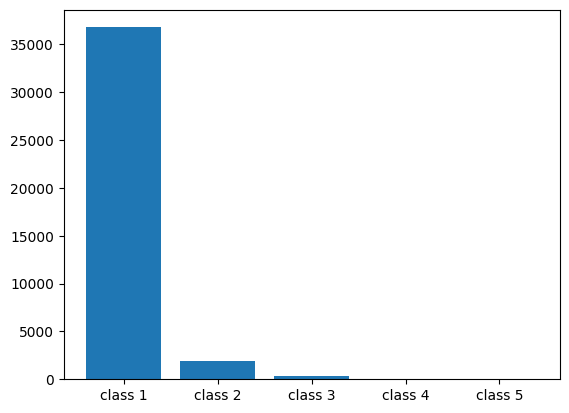

In [ ]:
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np

hist_values = []

for value in values:
  ctr = 0
  for item in precariousness_rate:
    if item[1] == value:
      ctr = ctr + 1
  hist_values.append((value, ctr))

class1 = []
class2 = []
class3 = []
class4 = []
class5 = []

for item in hist_values:
  if item[0] > 80:
    class5.append(item)
  elif item[0] > 60 and item[0] <= 80:
    class4.append(item)
  elif item[0] > 40 and item[0] <= 60:
    class3.append(item)
  elif item[0] > 20 and item[0] <= 40:
    class2.append(item)
  else:
    class1.append(item)

class_hist = []

number_of_individuals_in_class1 = 0
for item in class1:
  number_of_individuals_in_class1 = number_of_individuals_in_class1 + item[1]

number_of_individuals_in_class2 = 0
for item in class2:
  number_of_individuals_in_class2 = number_of_individuals_in_class2 + item[1]

number_of_individuals_in_class3 = 0
for item in class3:
  number_of_individuals_in_class3 = number_of_individuals_in_class3 + item[1]

number_of_individuals_in_class4 = 0
for item in class4:
  number_of_individuals_in_class4 = number_of_individuals_in_class4 + item[1]

number_of_individuals_in_class5 = 0
for item in class5:
  number_of_individuals_in_class5 = number_of_individuals_in_class5 + item[1]

class_hist.append(("class 1", number_of_individuals_in_class1))
class_hist.append(("class 2", number_of_individuals_in_class2))
class_hist.append(("class 3", number_of_individuals_in_class3))
class_hist.append(("class 4", number_of_individuals_in_class4))
class_hist.append(("class 5", number_of_individuals_in_class5))


for i in range(len(class_hist)):
  print("Number of individuals in class", i+1, ":", class_hist[i][1])

print("\nHistogram:")

val, cnt = (zip(*class_hist))
val, cnt = list(val), list(cnt)
val, cnt

length = len(cnt)
plt.bar(np.arange(length), cnt, label=True)
plt.xticks(np.arange(len(cnt)), val)
plt.show()

## Subjective Precariousness Rate

In [ ]:
indicators = ["row_id", "ifrjob", "evfrjob", "netifr", "grspfr", "hincfel"]
data2 = pd.DataFrame()
data2 = data.loc[data['EmploymentRelation'] == 1]
data2 = data2[indicators]
data2.head()

,row_id,ifrjob,evfrjob,netifr,grspfr,hincfel
0,0,10,5,-2,-2,3
1,1,10,8,0,6,2
2,2,8,8,0,0,1
5,5,3,4,0,6,1
6,6,6,6,-2,-2,2


In [ ]:
data2 = data2.to_numpy()

To estimate subjective precarity, a rescaling, ranging from 0 to 100, was performed to the five questions presented, giving a summated average subjective precarity score.

In [ ]:
precariousness_rate_sub = []

for row in range(len(data2)):
  sum = 0

  if data2[row][1] == 0:
    sum = sum + 100
  elif data2[row][1] == 1:
    sum = sum + 90
  elif data2[row][1] == 2:
    sum = sum + 80
  elif data2[row][1] == 3:
    sum = sum + 70
  elif data2[row][1] == 4:
    sum = sum + 60
  elif data2[row][1] == 5:
    sum = sum + 50
  elif data2[row][1] == 6:
    sum = sum + 40
  elif data2[row][1] == 7:
    sum = sum + 30
  elif data2[row][1] == 8:
    sum = sum + 20
  elif data2[row][1] == 9:
    sum = sum + 10

  if data2[row][2] == 0:
    sum = sum + 100
  elif data2[row][2] == 1:
    sum = sum + 90
  elif data2[row][2] == 2:
    sum = sum + 80
  elif data2[row][2] == 3:
    sum = sum + 70
  elif data2[row][2] == 4:
    sum = sum + 60
  elif data2[row][2] == 5:
    sum = sum + 50
  elif data2[row][2] == 6:
    sum = sum + 40
  elif data2[row][2] == 7:
    sum = sum + 30
  elif data2[row][2] == 8:
    sum = sum + 20
  elif data2[row][2] == 9:
    sum = sum + 10

  if data2[row][3] == 4:
    sum = sum + 0
  elif data2[row][3] == 3:
    sum = sum + 12.5
  elif data2[row][3] == 2:
    sum = sum + 25
  elif data2[row][3] == 1:
    sum = sum + 37.5
  elif data2[row][3] == 0:
    sum = sum + 50
  elif data2[row][3] == -1:
    sum = sum + 62.5
  elif data2[row][3] == -2:
    sum = sum + 75
  elif data2[row][3] == -3:
    sum = sum + 87.5
  elif data2[row][3] == -4:
    sum = sum + 100

  if data2[row][4] == 4:
    sum = sum + 0
  elif data2[row][4] == 3:
    sum = sum + 12.5
  elif data2[row][4] == 2:
    sum = sum + 25
  elif data2[row][4] == 1:
    sum = sum + 37.5
  elif data2[row][4] == 0:
    sum = sum + 50
  elif data2[row][4] == -1:
    sum = sum + 62.5
  elif data2[row][4] == -2:
    sum = sum + 75
  elif data2[row][4] == -3:
    sum = sum + 87.5
  elif data2[row][4] == -4:
    sum = sum + 100

  if data2[row][5] == 2:
    sum = sum + 33.3
  elif data2[row][5] == 3:
    sum = sum + 66.7
  elif data2[row][5] == 4:
    sum = sum + 100

  score = sum/5

  precariousness_rate_sub.append((int(data2[row][0]), int(score)))

print("Precariousness Rate Tuples:")
print(precariousness_rate_sub[0:40])
values = []
for item in precariousness_rate_sub:
  if item[1] not in values:
    values.append(item[1])

values_sorted = values.copy()
values_sorted.sort()
print("\nPrecariousness Rate Values:")
print(values_sorted)

Precariousness Rate Tuples:
[(0, 53), (1, 20), (2, 28), (5, 36), (6, 52), (8, 46), (9, 22), (10, 17), (12, 38), (13, 58), (14, 10), (15, 26), (16, 22), (17, 40), (18, 44), (19, 67), (20, 18), (22, 45), (23, 26), (24, 20), (25, 35), (27, 24), (28, 57), (29, 27), (30, 25), (31, 24), (32, 38), (33, 32), (34, 56), (35, 35), (36, 22), (37, 22), (38, 24), (39, 24), (40, 6), (41, 38), (42, 26), (43, 41), (44, 34), (45, 26)]

Precariousness Rate Values:
[0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100]


## Comparing Objective and Subjective Precariousness Rates

We estimate the difference of objective and subjective precariousness for each individual as shown below.

In [ ]:
diff = []

for i in range(len(precariousness_rate)):
  if precariousness_rate[i][0] == precariousness_rate_sub[i][0]:
    diff.append(precariousness_rate[i][1] - precariousness_rate_sub[i][1])

In [ ]:
number_of_individuals_that_underestimated_their_precariousness = 0
number_of_individuals_that_overestimated_their_precariousness = 0
number_of_individuals_that_correctly_estimated_their_precariousness = 0

for i in range(len(precariousness_rate)):
  if precariousness_rate[i][0] == precariousness_rate_sub[i][0]:
    if precariousness_rate[i][1] > 80:
      if precariousness_rate_sub[i][1] > 80:
        number_of_individuals_that_correctly_estimated_their_precariousness = number_of_individuals_that_correctly_estimated_their_precariousness + 1
      elif precariousness_rate_sub[i][1] <= 80:
        number_of_individuals_that_underestimated_their_precariousness = number_of_individuals_that_underestimated_their_precariousness + 1
    elif precariousness_rate[i][1] > 60 and precariousness_rate[i][1] <= 80:
      if precariousness_rate_sub[i][1] > 60 and precariousness_rate_sub[i][1] <= 80:
        number_of_individuals_that_correctly_estimated_their_precariousness = number_of_individuals_that_correctly_estimated_their_precariousness + 1
      elif precariousness_rate_sub[i][1] <= 60:
        number_of_individuals_that_underestimated_their_precariousness = number_of_individuals_that_underestimated_their_precariousness + 1
      elif precariousness_rate_sub[i][1] > 80:
        number_of_individuals_that_overestimated_their_precariousness = number_of_individuals_that_overestimated_their_precariousness + 1
    elif precariousness_rate[i][1] > 40 and precariousness_rate[i][1] <= 60:
      if precariousness_rate_sub[i][1] > 40 and precariousness_rate_sub[i][1] <= 60:
        number_of_individuals_that_correctly_estimated_their_precariousness = number_of_individuals_that_correctly_estimated_their_precariousness + 1
      elif precariousness_rate_sub[i][1] <= 40:
        number_of_individuals_that_underestimated_their_precariousness = number_of_individuals_that_underestimated_their_precariousness + 1
      elif precariousness_rate_sub[i][1] > 60:
        number_of_individuals_that_overestimated_their_precariousness = number_of_individuals_that_overestimated_their_precariousness + 1
    elif precariousness_rate[i][1] > 20 and precariousness_rate[i][1] <= 40:
      if precariousness_rate_sub[i][1] > 20 and precariousness_rate_sub[i][1] <= 40:
        number_of_individuals_that_correctly_estimated_their_precariousness = number_of_individuals_that_correctly_estimated_their_precariousness + 1
      elif precariousness_rate_sub[i][1] <= 20:
        number_of_individuals_that_underestimated_their_precariousness = number_of_individuals_that_underestimated_their_precariousness + 1
      elif precariousness_rate_sub[i][1] > 40:
        number_of_individuals_that_overestimated_their_precariousness = number_of_individuals_that_overestimated_their_precariousness + 1
    else:
      if precariousness_rate_sub[i][1] <= 20:
        number_of_individuals_that_correctly_estimated_their_precariousness = number_of_individuals_that_correctly_estimated_their_precariousness + 1
      elif precariousness_rate_sub[i][1] > 20:
        number_of_individuals_that_overestimated_their_precariousness = number_of_individuals_that_overestimated_their_precariousness + 1

print("Number of individuals that correctly estimated their precariousness = " + str(number_of_individuals_that_correctly_estimated_their_precariousness))
print("Number of individuals that underestimated their precariousness = " + str(number_of_individuals_that_underestimated_their_precariousness))
print("Number of individuals that overestimated their precariousness = " + str(number_of_individuals_that_overestimated_their_precariousness))

Number of individuals that correctly estimated their precariousness = 3743
Number of individuals that underestimated their precariousness = 445
Number of individuals that overestimated their precariousness = 34943


In [ ]:
import numpy as np

mean_obj = np.mean(pr)
mean_sub = np.mean(pr_sub)

mini = min(pr)
mini_sub = min(pr_sub)

maxi = max(pr)
maxi_sub = max(pr_sub)

print(mean_obj)
print(mean_sub)
print()
print(mini)
print(mini_sub)
print()
print(maxi)
print(maxi_sub)

5.111676164677621
42.46753213564693

0
0

82
100


## Results and Socio-demographic Characteristics

We examine the socio-demographic characteristics of employees that belong to different levels of precarity, to gain more insight on the characteristics of precarious workers.

###Gender

The following code calculates the number and percentages of men and women for each class of precarity.

In [ ]:
gender = ["row_id", "Gender"]
data_gender = pd.DataFrame()
data_gender = data.loc[data['EmploymentRelation'] == 1]
data_gender = data_gender[gender]

data_gender = data_gender.to_numpy()

men_in_class1 = 0
women_in_class1 = 0
men_in_class2 = 0
women_in_class2 = 0
men_in_class3 = 0
women_in_class3 = 0
men_in_class4 = 0
women_in_class4 = 0
men_in_class5 = 0
women_in_class5 = 0

for i in range(len(data_gender)):
  if precariousness_rate[i][1] <= 20:
    if data_gender[i][1] == 1:
      men_in_class1 = men_in_class1 + 1
    elif data_gender[i][1] == 2:
      women_in_class1 = women_in_class1 + 1
  elif precariousness_rate[i][1] > 20 and precariousness_rate[i][1] <= 40:
    if data_gender[i][1] == 1:
      men_in_class2 = men_in_class2 + 1
    elif data_gender[i][1] == 2:
      women_in_class2 = women_in_class2 + 1
  elif precariousness_rate[i][1] > 40 and precariousness_rate[i][1] <= 60:
    if data_gender[i][1] == 1:
      men_in_class3 = men_in_class3 + 1
    elif data_gender[i][1] == 2:
      women_in_class3 = women_in_class3 + 1
  elif precariousness_rate[i][1] > 60 and precariousness_rate[i][1] <= 80:
    if data_gender[i][1] == 1:
      men_in_class4 = men_in_class4 + 1
    elif data_gender[i][1] == 2:
      women_in_class4 = women_in_class4 + 1
  else:
    if data_gender[i][1] == 1:
      men_in_class5 = men_in_class5 + 1
    elif data_gender[i][1] == 2:
      women_in_class5 = women_in_class5 + 1

print("Class 1:")
print("Number of men:", men_in_class1)
print("Number of women:", women_in_class1)
print("Percentage of men:", (men_in_class1 / (men_in_class1 + women_in_class1)) * 100)
print("Percentage of women:", (women_in_class1 / (men_in_class1 + women_in_class1)) * 100)
print(" ")

print("Class 2:")
print("Number of men:", men_in_class2)
print("Number of women:", women_in_class2)
print("Percentage of men:", (men_in_class2 / (men_in_class2 + women_in_class2)) * 100)
print("Percentage of women:", (women_in_class2 / (men_in_class2 + women_in_class2)) * 100)
print(" ")

print("Class 3:")
print("Number of men:", men_in_class3)
print("Number of women:", women_in_class3)
print("Percentage of men:", (men_in_class3 / (men_in_class3 + women_in_class3)) * 100)
print("Percentage of women:", (women_in_class3 / (men_in_class3 + women_in_class3)) * 100)
print(" ")

print("Class 4:")
print("Number of men:", men_in_class4)
print("Number of women:", women_in_class4)
print("Percentage of men:", (men_in_class4 / (men_in_class4 + women_in_class4)) * 100)
print("Percentage of women:", (women_in_class4 / (men_in_class4 + women_in_class4)) * 100)
print(" ")

print("Class 5:")
print("Number of men:", men_in_class5)
print("Number of women:", women_in_class5)
print("Percentage of men:", (men_in_class5 / (men_in_class5 + women_in_class5)) * 100)
print("Percentage of women:", (women_in_class5 / (men_in_class5 + women_in_class5)) * 100)

Class 1:
Number of men: 16808
Number of women: 19981
Percentage of men: 45.68756965397265
Percentage of women: 54.31243034602734
 
Class 2:
Number of men: 874
Number of women: 1080
Percentage of men: 44.72876151484135
Percentage of women: 55.27123848515865
 
Class 3:
Number of men: 102
Number of women: 226
Percentage of men: 31.097560975609756
Percentage of women: 68.90243902439023
 
Class 4:
Number of men: 21
Number of women: 27
Percentage of men: 43.75
Percentage of women: 56.25
 
Class 5:
Number of men: 2
Number of women: 10
Percentage of men: 16.666666666666664
Percentage of women: 83.33333333333334


###Mean Age

Similarly, the following code calculates the mean age for each class of precarity.

In [ ]:
age = ["row_id", "Age"]
data_age = pd.DataFrame()
data_age = data.loc[data['EmploymentRelation'] == 1]
data_age = data_age[age]

data_age = data_age.to_numpy()

age_sum_in_class1 = 0
number_of_individuals_in_class1 = 0
age_sum_in_class2 = 0
number_of_individuals_in_class2 = 0
age_sum_in_class3 = 0
number_of_individuals_in_class3 = 0
age_sum_in_class4 = 0
number_of_individuals_in_class4 = 0
age_sum_in_class5 = 0
number_of_individuals_in_class5 = 0

for i in range(len(data_age)):
  if precariousness_rate[i][1] <= 20:
    age_sum_in_class1 = age_sum_in_class1 + data_age[i][1]
    number_of_individuals_in_class1 = number_of_individuals_in_class1 + 1
  elif precariousness_rate[i][1] > 20 and precariousness_rate[i][1] <= 40:
    age_sum_in_class2 = age_sum_in_class2 + data_age[i][1]
    number_of_individuals_in_class2 = number_of_individuals_in_class2 + 1
  elif precariousness_rate[i][1] > 40 and precariousness_rate[i][1] <= 60:
    age_sum_in_class3 = age_sum_in_class3 + data_age[i][1]
    number_of_individuals_in_class3 = number_of_individuals_in_class3 + 1
  elif precariousness_rate[i][1] > 60 and precariousness_rate[i][1] <= 80:
    age_sum_in_class4 = age_sum_in_class4 + data_age[i][1]
    number_of_individuals_in_class4 = number_of_individuals_in_class4 + 1
  else:
    age_sum_in_class5 = age_sum_in_class5 + data_age[i][1]
    number_of_individuals_in_class5 = number_of_individuals_in_class5 + 1


print("mean age in Class 1:", age_sum_in_class1/number_of_individuals_in_class1)
print(" ")

print("mean age in Class 2:", age_sum_in_class2/number_of_individuals_in_class2)
print(" ")

print("mean age in Class 3:", age_sum_in_class3/number_of_individuals_in_class3)
print(" ")

print("mean age in Class 4:", age_sum_in_class4/number_of_individuals_in_class4)
print(" ")

print("mean age in Class 5:", age_sum_in_class5/number_of_individuals_in_class5)

mean age in Class 1: 55.75957487292397
 
mean age in Class 2: 54.22722620266121
 
mean age in Class 3: 61.0640243902439
 
mean age in Class 4: 53.541666666666664
 
mean age in Class 5: 51.5


###Educational Level

Similarly, the following code calculates the percentages of low, medium and highly educated individuals for each class of precarity.

In [ ]:
education = ["row_id", "education"]
data_education = pd.DataFrame()
data_education = data.loc[data['EmploymentRelation'] == 1]
data_education = data_education[education]
data_education["education"] = data_education["education"].str.replace(',','.')

data_education = data_education.to_numpy()

ed1 = []
ed2 = []
ed3 = []
ed4 = []
ed5 = []


for i in range(4):
  ed1.append(0)
  ed2.append(0)
  ed3.append(0)
  ed4.append(0)
  ed5.append(0)


for i in range(len(data_education)):
  if precariousness_rate[i][1] <= 20:
    for j in range(4):
      if data_education[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education[i][1])) == j:
          ed1[j] = ed1[j] + 1
  elif precariousness_rate[i][1] > 20 and precariousness_rate[i][1] <= 40:
    for j in range(4):
      if data_education[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education[i][1])) == j:
          ed2[j] = ed2[j] + 1
  elif precariousness_rate[i][1] > 40 and precariousness_rate[i][1] <= 60:
    for j in range(4):
      if data_education[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education[i][1])) == j:
          ed3[j] = ed3[j] + 1
  elif precariousness_rate[i][1] > 60 and precariousness_rate[i][1] <= 80:
    for j in range(4):
      if data_education[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education[i][1])) == j:
          ed4[j] = ed4[j] + 1
  else:
    for j in range(4):
      if data_education[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education[i][1])) == j:
          ed5[j] = ed5[j] + 1


print("Class 1:")
sum = 0
for i in range(4):
  sum = sum + ed1[i]
print("Percentage of low educated individuals:", (ed1[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed1[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed1[3]/ sum) * 100)
print(" ")

print("Class 2:")
sum = 0
for i in range(4):
  sum = sum + ed2[i]
print("Percentage of low educated individuals:", (ed2[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed2[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed2[3]/ sum) * 100)
print(" ")

print("Class 3:")
sum = 0
for i in range(4):
  sum = sum + ed3[i]
print("Percentage of low educated individuals:", (ed3[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed3[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed3[3]/ sum) * 100)
print(" ")

print("Class 4:")
sum = 0
for i in range(4):
  sum = sum + ed4[i]
print("Percentage of low educated individuals:", (ed4[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed4[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed4[3]/ sum) * 100)
print(" ")

print("Class 5:")
sum = 0
for i in range(4):
  sum = sum + ed5[i]
print("Percentage of low educated individuals:", (ed5[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed5[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed5[3]/ sum) * 100)

Class 1:
Percentage of low educated individuals: 19.70916432488473
Percentage of medium educated individuals: 53.99012359152048
Percentage of highly educated individuals: 26.300712083594796
 
Class 2:
Percentage of low educated individuals: 42.577319587628864
Percentage of medium educated individuals: 42.78350515463917
Percentage of highly educated individuals: 14.63917525773196
 
Class 3:
Percentage of low educated individuals: 48.30769230769231
Percentage of medium educated individuals: 40.92307692307692
Percentage of highly educated individuals: 10.76923076923077
 
Class 4:
Percentage of low educated individuals: 61.702127659574465
Percentage of medium educated individuals: 34.04255319148936
Percentage of highly educated individuals: 4.25531914893617
 
Class 5:
Percentage of low educated individuals: 66.66666666666666
Percentage of medium educated individuals: 16.666666666666664
Percentage of highly educated individuals: 16.666666666666664


###Occupation

Similarly, we look into the occupation of individuals for each class of precarity. We examine 10 fields of occupation.

In [ ]:
occupation = ["row_id", "occupation"]
data_occupation = pd.DataFrame()
data_occupation = data.loc[data['EmploymentRelation'] == 1]
data_occupation = data_occupation[occupation]
data_occupation["occupation"] = data_occupation["occupation"].str.replace(',','.')

data_occupation = data_occupation.to_numpy()

oc1 = []
oc2 = []
oc3 = []
oc4 = []
oc5 = []


for i in range(10):
  oc1.append(0)
  oc2.append(0)
  oc3.append(0)
  oc4.append(0)
  oc5.append(0)


for i in range(len(data_occupation)):
  if precariousness_rate[i][1] <= 20:
    for j in range(10):
      if data_occupation[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation[i][1])) == j:
          oc1[j] = oc1[j] + 1
  elif precariousness_rate[i][1] > 20 and precariousness_rate[i][1] <= 40:
    for j in range(10):
      if data_occupation[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation[i][1])) == j:
          oc2[j] = oc2[j] + 1
  elif precariousness_rate[i][1] > 40 and precariousness_rate[i][1] <= 60:
    for j in range(10):
      if data_occupation[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation[i][1])) == j:
          oc3[j] = oc3[j] + 1
  elif precariousness_rate[i][1] > 60 and precariousness_rate[i][1] <= 80:
    for j in range(10):
      if data_occupation[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation[i][1])) == j:
          oc4[j] = oc4[j] + 1
  else:
    for j in range(10):
      if data_occupation[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation[i][1])) == j:
          oc5[j] = oc5[j] + 1


print("Class 1:")
sum = 0
for i in range(10):
  sum = sum + oc1[i]
print("Percentage of Armed Forces Occupations:", (oc1[0]/ sum) * 100)
print("Percentage of Managers:", (oc1[1]/ sum) * 100)
print("Percentage of Professionals:", (oc1[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc1[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc1[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc1[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc1[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc1[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc1[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc1[9]/ sum) * 100)
print(" ")

print("Class 2:")
sum = 0
for i in range(10):
  sum = sum + oc2[i]
print("Percentage of Armed Forces Occupations:", (oc2[0]/ sum) * 100)
print("Percentage of Managers:", (oc2[1]/ sum) * 100)
print("Percentage of Professionals:", (oc2[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc2[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc2[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc2[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc2[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc2[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc2[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc2[9]/ sum) * 100)
print(" ")

print("Class 3:")
sum = 0
for i in range(10):
  sum = sum + oc3[i]
print("Percentage of Armed Forces Occupations:", (oc3[0]/ sum) * 100)
print("Percentage of Managers:", (oc3[1]/ sum) * 100)
print("Percentage of Professionals:", (oc3[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc3[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc3[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc3[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc3[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc3[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc3[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc3[9]/ sum) * 100)
print(" ")

print("Class 4:")
sum = 0
for i in range(10):
  sum = sum + oc4[i]
print("Percentage of Armed Forces Occupations:", (oc4[0]/ sum) * 100)
print("Percentage of Managers:", (oc4[1]/ sum) * 100)
print("Percentage of Professionals:", (oc4[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc4[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc4[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc4[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc4[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc4[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc4[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc4[9]/ sum) * 100)
print(" ")

print("Class 5:")
sum = 0
for i in range(10):
  sum = sum + oc5[i]
print("Percentage of Armed Forces Occupations:", (oc5[0]/ sum) * 100)
print("Percentage of Managers:", (oc5[1]/ sum) * 100)
print("Percentage of Professionals:", (oc5[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc5[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc5[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc5[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc5[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc5[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc5[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc5[9]/ sum) * 100)

Class 1:
Percentage of Armed Forces Occupations: 0.4297520661157025
Percentage of Managers: 6.446280991735537
Percentage of Professionals: 20.134986225895315
Percentage of Technicians and Associate Professionals: 14.134986225895316
Percentage of Clerical Support Workers: 9.774104683195592
Percentage of Service and Sales Workers: 17.520661157024794
Percentage of Skilled Agricultural, Forestry and Fishery Workers: 1.1074380165289257
Percentage of Craft and Related Trades Workers: 11.517906336088155
Percentage of Plant and Machine Operators, and Assemblers: 8.462809917355372
Percentage of Elementary Occupations: 10.47107438016529
 
Class 2:
Percentage of Armed Forces Occupations: 0.3110419906687403
Percentage of Managers: 3.784344219803007
Percentage of Professionals: 10.10886469673406
Percentage of Technicians and Associate Professionals: 9.434940383618455
Percentage of Clerical Support Workers: 8.13893208916537
Percentage of Service and Sales Workers: 24.57231726283048
Percentage of Ski

###Citizenship

Finally, we examine the citizenship of individuals for each class of precarity.

In [ ]:
cit = ["row_id", "Citizen of country"]
data_cit = pd.DataFrame()
data_cit = data.loc[data['EmploymentRelation'] == 1]
data_cit = data_cit[cit]

data_cit = data_cit.to_numpy()

number_of_citizens_of_country_in_class1 = 0
number_of_non_citizens_of_country_in_class1 = 0
number_of_citizens_of_country_in_class2 = 0
number_of_non_citizens_of_country_in_class2 = 0
number_of_citizens_of_country_in_class3 = 0
number_of_non_citizens_of_country_in_class3 = 0
number_of_citizens_of_country_in_class4 = 0
number_of_non_citizens_of_country_in_class4 = 0
number_of_citizens_of_country_in_class5 = 0
number_of_non_citizens_of_country_in_class5 = 0

for i in range(len(data_cit)):
  if precariousness_rate[i][1] <= 20:
    if data_cit[i][1] == 1:
      number_of_citizens_of_country_in_class1 = number_of_citizens_of_country_in_class1 + 1
    elif data_cit[i][1] == 2:
      number_of_non_citizens_of_country_in_class1 = number_of_non_citizens_of_country_in_class1 + 1
  elif precariousness_rate[i][1] > 20 and precariousness_rate[i][1] <= 40:
    if data_cit[i][1] == 1:
      number_of_citizens_of_country_in_class2 = number_of_citizens_of_country_in_class2 + 1
    elif data_cit[i][1] == 2:
      number_of_non_citizens_of_country_in_class2 = number_of_non_citizens_of_country_in_class2 + 1
  elif precariousness_rate[i][1] > 40 and precariousness_rate[i][1] <= 60:
    if data_cit[i][1] == 1:
      number_of_citizens_of_country_in_class3 = number_of_citizens_of_country_in_class3 + 1
    elif data_cit[i][1] == 2:
      number_of_non_citizens_of_country_in_class3 = number_of_non_citizens_of_country_in_class3 + 1
  elif precariousness_rate[i][1] > 60 and precariousness_rate[i][1] <= 80:
    if data_cit[i][1] == 1:
      number_of_citizens_of_country_in_class4 = number_of_citizens_of_country_in_class4 + 1
    elif data_cit[i][1] == 2:
      number_of_non_citizens_of_country_in_class4 = number_of_non_citizens_of_country_in_class4 + 1
  else:
    if data_cit[i][1] == 1:
      number_of_citizens_of_country_in_class5 = number_of_citizens_of_country_in_class5 + 1
    elif data_cit[i][1] == 2:
      number_of_non_citizens_of_country_in_class5 = number_of_non_citizens_of_country_in_class5 + 1

print("Class 1:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class1 / (number_of_citizens_of_country_in_class1 + number_of_non_citizens_of_country_in_class1)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class1 / (number_of_citizens_of_country_in_class1 + number_of_non_citizens_of_country_in_class1)) * 100)
print(" ")

print("Class 2:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class2 / (number_of_citizens_of_country_in_class2 + number_of_non_citizens_of_country_in_class2)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class2 / (number_of_citizens_of_country_in_class2 + number_of_non_citizens_of_country_in_class2)) * 100)
print(" ")

print("Class 3:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class3 / (number_of_citizens_of_country_in_class3 + number_of_non_citizens_of_country_in_class3)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class3 / (number_of_citizens_of_country_in_class3 + number_of_non_citizens_of_country_in_class3)) * 100)
print(" ")

print("Class 4:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class4 / (number_of_citizens_of_country_in_class4 + number_of_non_citizens_of_country_in_class4)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class4 / (number_of_citizens_of_country_in_class4 + number_of_non_citizens_of_country_in_class4)) * 100)
print(" ")

print("Class 5:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class5 / (number_of_citizens_of_country_in_class5 + number_of_non_citizens_of_country_in_class5)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class5 / (number_of_citizens_of_country_in_class5 + number_of_non_citizens_of_country_in_class5)) * 100)

Class 1:
Percentage of citizens of country: 95.30038891457477
Percentage of non citizens of country: 4.699611085425222
 
Class 2:
Percentage of citizens of country: 94.26229508196722
Percentage of non citizens of country: 5.737704918032787
 
Class 3:
Percentage of citizens of country: 92.04892966360856
Percentage of non citizens of country: 7.951070336391437
 
Class 4:
Percentage of citizens of country: 95.74468085106383
Percentage of non citizens of country: 4.25531914893617
 
Class 5:
Percentage of citizens of country: 100.0
Percentage of non citizens of country: 0.0


## Cross-country comparison: Germany, Finland, Italy, and Lithuania

We apply previously provided code and present the example of four countries of different characteristics: Germany, Finland, Italy, and Lithuania. For each country, we assess precarity scores of employees and examine their socio-demographic characteristics, in order to extract knowledge for each country and make comparisons.

###The Case of Germany

####Implementation

In [ ]:
indicators = ["row_id", "HoursWorked", "EmploymentContract", "SetHours", "HouseholdsIncome", "netilet"]
data_germany = pd.DataFrame()
data_germany = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "DE")]
data_germany = data_germany[indicators]
data_germany.head()

,row_id,HoursWorked,EmploymentContract,SetHours,HouseholdsIncome,netilet
11185,11185,17,1,1,3,66
11186,11186,40,1,1,6,66
11188,11188,40,1,1,6,66
11191,11191,30,1,1,4,66
11192,11192,38,2,1,5,66


In [ ]:
data_germany = data_germany.to_numpy()

In [ ]:
precariousness_rate_germany = []

for row in range(len(data_germany)):
  ScoreIE = 0
  if data_germany[row][1] != "#ΚΕΝΟ!":
    if int(data_germany[row][1]) <= 30:
      ScoreIE = ScoreIE + 35
  if data_germany[row][2] == 2 or data_germany[row][2] == 3:
    ScoreIE = ScoreIE + 35
  if data_germany[row][3] == 2:
    ScoreIE = ScoreIE + 30
  ScoreUE = 0
  if data_germany[row][2] == 3:
    ScoreUE = ScoreUE + 100
  ScoreIR = 0
  if data_germany[row][4] <= 3:
    ScoreIR = ScoreIR + 40
  if data_germany[row][5] <= 3:
    ScoreIR = ScoreIR + 60

  w1 = 1 + ScoreIE/100
  w2 = 1 + ScoreUE/100
  w3 = 1 + ScoreIR/100
  score = (w1*w2*w3 - 1) * 100 / 7
  precariousness_rate_germany.append((int(data_germany[row][0]), int(score)))

print("Precariousness Rate Tuples:")
print(precariousness_rate_germany[0:40])

values = []
for item in precariousness_rate_germany:
  if item[1] not in values:
    values.append(item[1])

values_sorted = values.copy()
values_sorted.sort()
print("\nPrecariousness Rate Values:")
print(values_sorted)

Precariousness Rate Tuples:
[(11185, 12), (11186, 0), (11188, 0), (11191, 5), (11192, 5), (11193, 12), (11194, 0), (11196, 5), (11197, 0), (11198, 0), (11199, 0), (11201, 0), (11202, 12), (11204, 0), (11205, 23), (11206, 0), (11207, 0), (11208, 12), (11209, 5), (11210, 0), (11211, 5), (11212, 0), (11213, 0), (11214, 4), (11215, 0), (11216, 0), (11217, 5), (11219, 5), (11220, 5), (11221, 0), (11222, 0), (11223, 4), (11224, 10), (11225, 0), (11226, 5), (11227, 0), (11229, 5), (11230, 8), (11232, 5), (11233, 0)]

Precariousness Rate Values:
[0, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 22, 23, 24, 32, 34, 39, 51, 53, 80]


[(12, 130), (0, 957), (5, 615), (23, 2), (4, 44), (10, 66), (8, 11), (39, 8), (11, 12), (9, 8), (19, 43), (24, 18), (16, 12), (80, 1), (22, 1), (53, 5), (32, 7), (34, 14), (51, 2), (14, 2), (15, 1), (18, 1)]
Number of individuals in class 1 : 1902
Number of individuals in class 2 : 50
Number of individuals in class 3 : 7
Number of individuals in class 4 : 1
Number of individuals in class 5 : 0

Histogram:


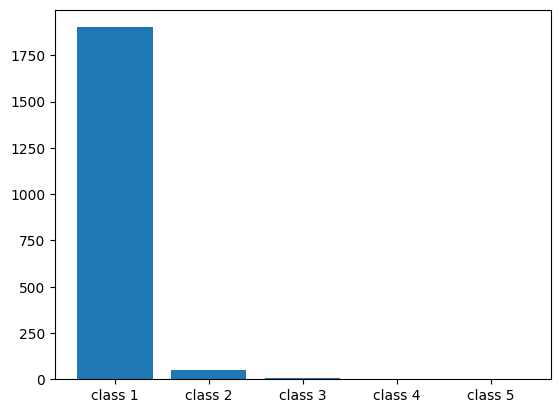

In [ ]:
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np

hist_values = []

for value in values:
  ctr = 0
  for item in precariousness_rate_germany:
    if item[1] == value:
      ctr = ctr + 1
  hist_values.append((value, ctr))

print(hist_values)

class1 = []
class2 = []
class3 = []
class4 = []
class5 = []

for item in hist_values:
  if item[0] > 80:
    class5.append(item)
  elif item[0] > 60 and item[0] <= 80:
    class4.append(item)
  elif item[0] > 40 and item[0] <= 60:
    class3.append(item)
  elif item[0] > 20 and item[0] <= 40:
    class2.append(item)
  else:
    class1.append(item)

class_hist = []

number_of_individuals_in_class1 = 0
for item in class1:
  number_of_individuals_in_class1 = number_of_individuals_in_class1 + item[1]

number_of_individuals_in_class2 = 0
for item in class2:
  number_of_individuals_in_class2 = number_of_individuals_in_class2 + item[1]

number_of_individuals_in_class3 = 0
for item in class3:
  number_of_individuals_in_class3 = number_of_individuals_in_class3 + item[1]

number_of_individuals_in_class4 = 0
for item in class4:
  number_of_individuals_in_class4 = number_of_individuals_in_class4 + item[1]

number_of_individuals_in_class5 = 0
for item in class5:
  number_of_individuals_in_class5 = number_of_individuals_in_class5 + item[1]

class_hist.append(("class 1", number_of_individuals_in_class1))
class_hist.append(("class 2", number_of_individuals_in_class2))
class_hist.append(("class 3", number_of_individuals_in_class3))
class_hist.append(("class 4", number_of_individuals_in_class4))
class_hist.append(("class 5", number_of_individuals_in_class5))

for i in range(len(class_hist)):
  print("Number of individuals in class", i+1, ":", class_hist[i][1])

print("\nHistogram:")

val, cnt = (zip(*class_hist))
val, cnt = list(val), list(cnt)
val, cnt

length = len(cnt)
plt.bar(np.arange(length), cnt, label=True)
plt.xticks(np.arange(len(cnt)), val)
plt.show()

In [ ]:
indicators = ["row_id", "ifrjob", "evfrjob", "netifr", "grspfr", "hincfel"]
data2_germany = pd.DataFrame()
data2_germany = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "DE")]
data2_germany = data2_germany[indicators]
data2_germany.head()

,row_id,ifrjob,evfrjob,netifr,grspfr,hincfel
11185,11185,10,8,0,0,2
11186,11186,5,6,0,6,2
11188,11188,8,3,-3,6,2
11191,11191,7,7,0,6,1
11192,11192,7,7,-1,-1,2


In [ ]:
data2_germany = data2_germany.to_numpy()

In [ ]:
precariousness_rate_sub_germany = []

for row in range(len(data2_germany)):
  sum = 0

  if data2_germany[row][1] == 0:
    sum = sum + 100
  elif data2_germany[row][1] == 1:
    sum = sum + 90
  elif data2_germany[row][1] == 2:
    sum = sum + 80
  elif data2_germany[row][1] == 3:
    sum = sum + 70
  elif data2_germany[row][1] == 4:
    sum = sum + 60
  elif data2_germany[row][1] == 5:
    sum = sum + 50
  elif data2_germany[row][1] == 6:
    sum = sum + 40
  elif data2_germany[row][1] == 7:
    sum = sum + 30
  elif data2_germany[row][1] == 8:
    sum = sum + 20
  elif data2_germany[row][1] == 9:
    sum = sum + 10

  if data2_germany[row][2] == 0:
    sum = sum + 100
  elif data2_germany[row][2] == 1:
    sum = sum + 90
  elif data2_germany[row][2] == 2:
    sum = sum + 80
  elif data2_germany[row][2] == 3:
    sum = sum + 70
  elif data2_germany[row][2] == 4:
    sum = sum + 60
  elif data2_germany[row][2] == 5:
    sum = sum + 50
  elif data2_germany[row][2] == 6:
    sum = sum + 40
  elif data2_germany[row][2] == 7:
    sum = sum + 30
  elif data2_germany[row][2] == 8:
    sum = sum + 20
  elif data2_germany[row][2] == 9:
    sum = sum + 10

  if data2_germany[row][3] == 4:
    sum = sum + 0
  elif data2_germany[row][3] == 3:
    sum = sum + 12.5
  elif data2_germany[row][3] == 2:
    sum = sum + 25
  elif data2_germany[row][3] == 1:
    sum = sum + 37.5
  elif data2_germany[row][3] == 0:
    sum = sum + 50
  elif data2_germany[row][3] == -1:
    sum = sum + 62.5
  elif data2_germany[row][3] == -2:
    sum = sum + 75
  elif data2_germany[row][3] == -3:
    sum = sum + 87.5
  elif data2_germany[row][3] == -4:
    sum = sum + 100

  if data2_germany[row][4] == 4:
    sum = sum + 0
  elif data2_germany[row][4] == 3:
    sum = sum + 12.5
  elif data2_germany[row][4] == 2:
    sum = sum + 25
  elif data2_germany[row][4] == 1:
    sum = sum + 37.5
  elif data2_germany[row][4] == 0:
    sum = sum + 50
  elif data2_germany[row][4] == -1:
    sum = sum + 62.5
  elif data2_germany[row][4] == -2:
    sum = sum + 75
  elif data2_germany[row][4] == -3:
    sum = sum + 87.5
  elif data2_germany[row][4] == -4:
    sum = sum + 100

  if data2_germany[row][5] == 2:
    sum = sum + 33.3
  elif data2_germany[row][5] == 3:
    sum = sum + 66.7
  elif data2_germany[row][5] == 4:
    sum = sum + 100

  score = sum/5

  precariousness_rate_sub_germany.append((int(data2_germany[row][0]), int(score)))

#precariousness_rate.sort(key=lambda tup: tup[1], reverse=True)
print("Precariousness Rate Tuples:")
print(precariousness_rate_sub_germany[0:40])
values = []
for item in precariousness_rate_sub_germany:
  if item[1] not in values:
    values.append(item[1])

values_sorted = values.copy()
values_sorted.sort()
print("\nPrecariousness Rate Values:")
print(values_sorted)

Precariousness Rate Tuples:
[(11185, 30), (11186, 34), (11188, 42), (11191, 22), (11192, 43), (11193, 31), (11194, 32), (11196, 31), (11197, 24), (11198, 32), (11199, 20), (11201, 22), (11202, 65), (11204, 26), (11205, 31), (11206, 54), (11207, 24), (11208, 42), (11209, 35), (11210, 32), (11211, 18), (11212, 47), (11213, 52), (11214, 46), (11215, 22), (11216, 27), (11217, 24), (11219, 48), (11220, 28), (11221, 57), (11222, 47), (11223, 26), (11224, 22), (11225, 18), (11226, 42), (11227, 45), (11229, 25), (11230, 44), (11232, 50), (11233, 28)]

Precariousness Rate Values:
[0, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 80, 82, 83, 87, 91, 94]


In [ ]:
mean_obj = np.mean(pr_germany)
mean_sub = np.mean(pr_sub_germany)

mini = min(pr_germany)
mini_sub = min(pr_sub_germany)

maxi = max(pr_germany)
maxi_sub = max(pr_sub_germany)

print(mean_obj)
print(mean_sub)
print()
print(mini)
print(mini_sub)
print()
print(maxi)
print(maxi_sub)

4.485714285714286
37.56122448979592

0
0

80
94


#### Socio-demographic Characteristics

#####Gender

In [ ]:
gender = ["row_id", "Gender"]
data_gender_germany = pd.DataFrame()
data_gender_germany = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "DE")]
data_gender_germany = data_gender_germany[gender]

data_gender_germany = data_gender_germany.to_numpy()

men_in_class1 = 0
women_in_class1 = 0
men_in_class2 = 0
women_in_class2 = 0
men_in_class3 = 0
women_in_class3 = 0
men_in_class4 = 0
women_in_class4 = 0
men_in_class5 = 0
women_in_class5 = 0

for i in range(len(data_gender_germany)):
  if precariousness_rate_germany[i][1] <= 20:
    if data_gender_germany[i][1] == 1:
      men_in_class1 = men_in_class1 + 1
    elif data_gender_germany[i][1] == 2:
      women_in_class1 = women_in_class1 + 1
  elif precariousness_rate_germany[i][1] > 20 and precariousness_rate_germany[i][1] <= 40:
    if data_gender_germany[i][1] == 1:
      men_in_class2 = men_in_class2 + 1
    elif data_gender_germany[i][1] == 2:
      women_in_class2 = women_in_class2 + 1
  elif precariousness_rate_germany[i][1] > 40 and precariousness_rate_germany[i][1] <= 60:
    if data_gender_germany[i][1] == 1:
      men_in_class3 = men_in_class3 + 1
    elif data_gender_germany[i][1] == 2:
      women_in_class3 = women_in_class3 + 1
  elif precariousness_rate_germany[i][1] > 60 and precariousness_rate_germany[i][1] <= 80:
    if data_gender_germany[i][1] == 1:
      men_in_class4 = men_in_class4 + 1
    elif data_gender_germany[i][1] == 2:
      women_in_class4 = women_in_class4 + 1
  else:
    if data_gender_germany[i][1] == 1:
      men_in_class5 = men_in_class5 + 1
    elif data_gender_germany[i][1] == 2:
      women_in_class5 = women_in_class5 + 1

print("Class 1:")
print("Number of men:", men_in_class1)
print("Number of women:", women_in_class1)
print("Percentage of men:", (men_in_class1 / (men_in_class1 + women_in_class1)) * 100)
print("Percentage of women:", (women_in_class1 / (men_in_class1 + women_in_class1)) * 100)
print(" ")

print("Class 2:")
print("Number of men:", men_in_class2)
print("Number of women:", women_in_class2)
print("Percentage of men:", (men_in_class2 / (men_in_class2 + women_in_class2)) * 100)
print("Percentage of women:", (women_in_class2 / (men_in_class2 + women_in_class2)) * 100)
print(" ")

print("Class 3:")
print("Number of men:", men_in_class3)
print("Number of women:", women_in_class3)
print("Percentage of men:", (men_in_class3 / (men_in_class3 + women_in_class3)) * 100)
print("Percentage of women:", (women_in_class3 / (men_in_class3 + women_in_class3)) * 100)
print(" ")

print("Class 4:")
print("Number of men:", men_in_class4)
print("Number of women:", women_in_class4)
print("Percentage of men:", (men_in_class4 / (men_in_class4 + women_in_class4)) * 100)
print("Percentage of women:", (women_in_class4 / (men_in_class4 + women_in_class4)) * 100)
print(" ")

print("Class 5:")
print("Number of men:", men_in_class5)
print("Number of women:", women_in_class5)
#print("Percentage of men:", (men_in_class5 / (men_in_class5 + women_in_class5)) * 100)
#print("Percentage of women:", (women_in_class5 / (men_in_class5 + women_in_class5)) * 100)

Class 1:
Number of men: 963
Number of women: 939
Percentage of men: 50.63091482649842
Percentage of women: 49.369085173501574
 
Class 2:
Number of men: 29
Number of women: 21
Percentage of men: 57.99999999999999
Percentage of women: 42.0
 
Class 3:
Number of men: 3
Number of women: 4
Percentage of men: 42.857142857142854
Percentage of women: 57.14285714285714
 
Class 4:
Number of men: 1
Number of women: 0
Percentage of men: 100.0
Percentage of women: 0.0
 
Class 5:
Number of men: 0
Number of women: 0


#####Mean Age

In [ ]:
age = ["row_id", "Age"]
data_age_germany = pd.DataFrame()
data_age_germany = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "DE")]
data_age_germany = data_age_germany[age]

data_age_germany = data_age_germany.to_numpy()

age_sum_in_class1 = 0
number_of_individuals_in_class1 = 0
age_sum_in_class2 = 0
number_of_individuals_in_class2 = 0
age_sum_in_class3 = 0
number_of_individuals_in_class3 = 0
age_sum_in_class4 = 0
number_of_individuals_in_class4 = 0
age_sum_in_class5 = 0
number_of_individuals_in_class5 = 0

for i in range(len(data_age_germany)):
  if precariousness_rate_germany[i][1] <= 20:
    age_sum_in_class1 = age_sum_in_class1 + data_age_germany[i][1]
    number_of_individuals_in_class1 = number_of_individuals_in_class1 + 1
  elif precariousness_rate_germany[i][1] > 20 and precariousness_rate_germany[i][1] <= 40:
    age_sum_in_class2 = age_sum_in_class2 + data_age_germany[i][1]
    number_of_individuals_in_class2 = number_of_individuals_in_class2 + 1
  elif precariousness_rate_germany[i][1] > 40 and precariousness_rate_germany[i][1] <= 60:
    age_sum_in_class3 = age_sum_in_class3 + data_age_germany[i][1]
    number_of_individuals_in_class3 = number_of_individuals_in_class3 + 1
  elif precariousness_rate_germany[i][1] > 60 and precariousness_rate_germany[i][1] <= 80:
    age_sum_in_class4 = age_sum_in_class4 + data_age_germany[i][1]
    number_of_individuals_in_class4 = number_of_individuals_in_class4 + 1
  else:
    age_sum_in_class5 = age_sum_in_class5 + data_age_germany[i][1]
    number_of_individuals_in_class5 = number_of_individuals_in_class5 + 1


print("mean age in Class 1:", age_sum_in_class1/number_of_individuals_in_class1)
print(" ")

print("mean age in Class 2:", age_sum_in_class2/number_of_individuals_in_class2)
print(" ")

print("mean age in Class 3:", age_sum_in_class3/number_of_individuals_in_class3)
print(" ")

print("mean age in Class 4:", age_sum_in_class4/number_of_individuals_in_class4)
print(" ")

print("mean age in Class 5: -")

mean age in Class 1: 52.11671924290221
 
mean age in Class 2: 48.54
 
mean age in Class 3: 54.714285714285715
 
mean age in Class 4: 29.0
 
mean age in Class 5: -


#####Educational Level

In [ ]:
education = ["row_id", "education"]
data_education_germany = pd.DataFrame()
data_education_germany = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "DE")]
data_education_germany = data_education_germany[education]
data_education_germany["education"] = data_education_germany["education"].str.replace(',','.')

data_education_germany = data_education_germany.to_numpy()

ed1 = []
ed2 = []
ed3 = []
ed4 = []
ed5 = []


for i in range(4):
  ed1.append(0)
  ed2.append(0)
  ed3.append(0)
  ed4.append(0)
  ed5.append(0)


for i in range(len(data_education_germany)):
  if precariousness_rate_germany[i][1] <= 20:
    for j in range(4):
      if data_education_germany[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_germany[i][1])) == j:
          ed1[j] = ed1[j] + 1
  elif precariousness_rate_germany[i][1] > 20 and precariousness_rate_germany[i][1] <= 40:
    for j in range(4):
      if data_education_germany[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_germany[i][1])) == j:
          ed2[j] = ed2[j] + 1
  elif precariousness_rate_germany[i][1] > 40 and precariousness_rate_germany[i][1] <= 60:
    for j in range(4):
      if data_education_germany[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_germany[i][1])) == j:
          ed3[j] = ed3[j] + 1
  elif precariousness_rate_germany[i][1] > 60 and precariousness_rate_germany[i][1] <= 80:
    for j in range(4):
      if data_education_germany[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_germany[i][1])) == j:
          ed4[j] = ed4[j] + 1
  else:
    for j in range(4):
      if data_education_germany[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_germany[i][1])) == j:
          ed5[j] = ed5[j] + 1


print("Class 1:")
sum = 0
for i in range(4):
  sum = sum + ed1[i]
print("Percentage of low educated individuals:", (ed1[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed1[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed1[3]/ sum) * 100)
print(" ")

print("Class 2:")
sum = 0
for i in range(4):
  sum = sum + ed2[i]
print("Percentage of low educated individuals:", (ed2[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed2[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed2[3]/ sum) * 100)
print(" ")

print("Class 3:")
sum = 0
for i in range(4):
  sum = sum + ed3[i]
print("Percentage of low educated individuals:", (ed3[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed3[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed3[3]/ sum) * 100)
print(" ")

print("Class 4:")
sum = 0
for i in range(4):
  sum = sum + ed4[i]
print("Percentage of low educated individuals:", (ed4[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed4[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed4[3]/ sum) * 100)
print(" ")

print("Class 5:")
sum = 0
for i in range(4):
  sum = sum + ed5[i]
#print("Percentage of low educated individuals:", (ed5[1]/ sum) * 100)
#print("Percentage of medium educated individuals:", (ed5[2]/ sum) * 100)
#print("Percentage of highly educated individuals:", (ed5[3]/ sum) * 100)

Class 1:
Percentage of low educated individuals: 8.851422550052687
Percentage of medium educated individuals: 64.12012644889357
Percentage of highly educated individuals: 27.02845100105374
 
Class 2:
Percentage of low educated individuals: 36.0
Percentage of medium educated individuals: 56.00000000000001
Percentage of highly educated individuals: 8.0
 
Class 3:
Percentage of low educated individuals: 14.285714285714285
Percentage of medium educated individuals: 57.14285714285714
Percentage of highly educated individuals: 28.57142857142857
 
Class 4:
Percentage of low educated individuals: 0.0
Percentage of medium educated individuals: 100.0
Percentage of highly educated individuals: 0.0
 
Class 5:


#####Occupation

In [ ]:
occupation = ["row_id", "occupation"]
data_occupation_germany = pd.DataFrame()
data_occupation_germany = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "DE")]
data_occupation_germany = data_occupation_germany[occupation]
data_occupation_germany["occupation"] = data_occupation_germany["occupation"].str.replace(',','.')

data_occupation_germany = data_occupation_germany.to_numpy()

oc1 = []
oc2 = []
oc3 = []
oc4 = []
oc5 = []


for i in range(10):
  oc1.append(0)
  oc2.append(0)
  oc3.append(0)
  oc4.append(0)
  oc5.append(0)


for i in range(len(data_occupation_germany)):
  if precariousness_rate_germany[i][1] <= 20:
    for j in range(10):
      if data_occupation_germany[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_germany[i][1])) == j:
          oc1[j] = oc1[j] + 1
  elif precariousness_rate_germany[i][1] > 20 and precariousness_rate_germany[i][1] <= 40:
    for j in range(10):
      if data_occupation_germany[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_germany[i][1])) == j:
          oc2[j] = oc2[j] + 1
  elif precariousness_rate_germany[i][1] > 40 and precariousness_rate_germany[i][1] <= 60:
    for j in range(10):
      if data_occupation_germany[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_germany[i][1])) == j:
          oc3[j] = oc3[j] + 1
  elif precariousness_rate_germany[i][1] > 60 and precariousness_rate_germany[i][1] <= 80:
    for j in range(10):
      if data_occupation_germany[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_germany[i][1])) == j:
          oc4[j] = oc4[j] + 1
  else:
    for j in range(10):
      if data_occupation_germany[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_germany[i][1])) == j:
          oc5[j] = oc5[j] + 1


print("Class 1:")
sum = 0
for i in range(10):
  sum = sum + oc1[i]
print("Percentage of Armed Forces Occupations:", (oc1[0]/ sum) * 100)
print("Percentage of Managers:", (oc1[1]/ sum) * 100)
print("Percentage of Professionals:", (oc1[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc1[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc1[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc1[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc1[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc1[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc1[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc1[9]/ sum) * 100)
print(" ")

print("Class 2:")
sum = 0
for i in range(10):
  sum = sum + oc2[i]
print("Percentage of Armed Forces Occupations:", (oc2[0]/ sum) * 100)
print("Percentage of Managers:", (oc2[1]/ sum) * 100)
print("Percentage of Professionals:", (oc2[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc2[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc2[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc2[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc2[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc2[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc2[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc2[9]/ sum) * 100)
print(" ")

print("Class 3:")
sum = 0
for i in range(10):
  sum = sum + oc3[i]
print("Percentage of Armed Forces Occupations:", (oc3[0]/ sum) * 100)
print("Percentage of Managers:", (oc3[1]/ sum) * 100)
print("Percentage of Professionals:", (oc3[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc3[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc3[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc3[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc3[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc3[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc3[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc3[9]/ sum) * 100)
print(" ")

print("Class 4:")
sum = 0
for i in range(10):
  sum = sum + oc4[i]
print("Percentage of Armed Forces Occupations:", (oc4[0]/ sum) * 100)
print("Percentage of Managers:", (oc4[1]/ sum) * 100)
print("Percentage of Professionals:", (oc4[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc4[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc4[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc4[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc4[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc4[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc4[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc4[9]/ sum) * 100)
print(" ")

print("Class 5:")
sum = 0
for i in range(10):
  sum = sum + oc5[i]
#print("Percentage of Armed Forces Occupations:", (oc5[0]/ sum) * 100)
#print("Percentage of Managers:", (oc5[1]/ sum) * 100)
#print("Percentage of Professionals:", (oc5[2]/ sum) * 100)
#print("Percentage of Technicians and Associate Professionals:", (oc5[3]/ sum) * 100)
#print("Percentage of Clerical Support Workers:", (oc5[4]/ sum) * 100)
#print("Percentage of Service and Sales Workers:", (oc5[5]/ sum) * 100)
#print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc5[6]/ sum) * 100)
#print("Percentage of Craft and Related Trades Workers:", (oc5[7]/ sum) * 100)
#print("Percentage of Plant and Machine Operators, and Assemblers:", (oc5[8]/ sum) * 100)
#print("Percentage of Elementary Occupations:", (oc5[9]/ sum) * 100)

Class 1:
Percentage of Armed Forces Occupations: 0.31762837480148226
Percentage of Managers: 7.517204870301747
Percentage of Professionals: 21.492853361566965
Percentage of Technicians and Associate Professionals: 22.3928004235045
Percentage of Clerical Support Workers: 12.387506617257808
Percentage of Service and Sales Workers: 11.964002117522499
Percentage of Skilled Agricultural, Forestry and Fishery Workers: 0.7940709370037057
Percentage of Craft and Related Trades Workers: 11.169931180518793
Percentage of Plant and Machine Operators, and Assemblers: 5.611434621492854
Percentage of Elementary Occupations: 6.352567496029645
 
Class 2:
Percentage of Armed Forces Occupations: 0.0
Percentage of Managers: 2.0
Percentage of Professionals: 4.0
Percentage of Technicians and Associate Professionals: 18.0
Percentage of Clerical Support Workers: 10.0
Percentage of Service and Sales Workers: 20.0
Percentage of Skilled Agricultural, Forestry and Fishery Workers: 2.0
Percentage of Craft and Rela

#####Citizenship

In [ ]:
cit = ["row_id", "Citizen of country"]
data_cit_germany = pd.DataFrame()
data_cit_germany = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "DE")]
data_cit_germany = data_cit_germany[cit]

data_cit_germany = data_cit_germany.to_numpy()

number_of_citizens_of_country_in_class1 = 0
number_of_non_citizens_of_country_in_class1 = 0
number_of_citizens_of_country_in_class2 = 0
number_of_non_citizens_of_country_in_class2 = 0
number_of_citizens_of_country_in_class3 = 0
number_of_non_citizens_of_country_in_class3 = 0
number_of_citizens_of_country_in_class4 = 0
number_of_non_citizens_of_country_in_class4 = 0
number_of_citizens_of_country_in_class5 = 0
number_of_non_citizens_of_country_in_class5 = 0

for i in range(len(data_cit_germany)):
  if precariousness_rate_germany[i][1] <= 20:
    if data_cit_germany[i][1] == 1:
      number_of_citizens_of_country_in_class1 = number_of_citizens_of_country_in_class1 + 1
    elif data_cit_germany[i][1] == 2:
      number_of_non_citizens_of_country_in_class1 = number_of_non_citizens_of_country_in_class1 + 1
  elif precariousness_rate_germany[i][1] > 20 and precariousness_rate_germany[i][1] <= 40:
    if data_cit_germany[i][1] == 1:
      number_of_citizens_of_country_in_class2 = number_of_citizens_of_country_in_class2 + 1
    elif data_cit_germany[i][1] == 2:
      number_of_non_citizens_of_country_in_class2 = number_of_non_citizens_of_country_in_class2 + 1
  elif precariousness_rate_germany[i][1] > 40 and precariousness_rate_germany[i][1] <= 60:
    if data_cit_germany[i][1] == 1:
      number_of_citizens_of_country_in_class3 = number_of_citizens_of_country_in_class3 + 1
    elif data_cit_germany[i][1] == 2:
      number_of_non_citizens_of_country_in_class3 = number_of_non_citizens_of_country_in_class3 + 1
  elif precariousness_rate_germany[i][1] > 60 and precariousness_rate_germany[i][1] <= 80:
    if data_cit_germany[i][1] == 1:
      number_of_citizens_of_country_in_class4 = number_of_citizens_of_country_in_class4 + 1
    elif data_cit_germany[i][1] == 2:
      number_of_non_citizens_of_country_in_class4 = number_of_non_citizens_of_country_in_class4 + 1
  else:
    if data_cit_germany[i][1] == 1:
      number_of_citizens_of_country_in_class5 = number_of_citizens_of_country_in_class5 + 1
    elif data_cit_germany[i][1] == 2:
      number_of_non_citizens_of_country_in_class5 = number_of_non_citizens_of_country_in_class5 + 1

print("Class 1:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class1 / (number_of_citizens_of_country_in_class1 + number_of_non_citizens_of_country_in_class1)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class1 / (number_of_citizens_of_country_in_class1 + number_of_non_citizens_of_country_in_class1)) * 100)
print(" ")

print("Class 2:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class2 / (number_of_citizens_of_country_in_class2 + number_of_non_citizens_of_country_in_class2)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class2 / (number_of_citizens_of_country_in_class2 + number_of_non_citizens_of_country_in_class2)) * 100)
print(" ")

print("Class 3:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class3 / (number_of_citizens_of_country_in_class3 + number_of_non_citizens_of_country_in_class3)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class3 / (number_of_citizens_of_country_in_class3 + number_of_non_citizens_of_country_in_class3)) * 100)
print(" ")

print("Class 4:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class4 / (number_of_citizens_of_country_in_class4 + number_of_non_citizens_of_country_in_class4)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class4 / (number_of_citizens_of_country_in_class4 + number_of_non_citizens_of_country_in_class4)) * 100)
print(" ")

print("Class 5:")
#print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class5 / (number_of_citizens_of_country_in_class5 + number_of_non_citizens_of_country_in_class5)) * 100)
#print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class5 / (number_of_citizens_of_country_in_class5 + number_of_non_citizens_of_country_in_class5)) * 100)

Class 1:
Percentage of citizens of country: 93.69085173501577
Percentage of non citizens of country: 6.309148264984227
 
Class 2:
Percentage of citizens of country: 88.0
Percentage of non citizens of country: 12.0
 
Class 3:
Percentage of citizens of country: 85.71428571428571
Percentage of non citizens of country: 14.285714285714285
 
Class 4:
Percentage of citizens of country: 100.0
Percentage of non citizens of country: 0.0
 
Class 5:


###The Case of Finland

####Implementation

In [ ]:
indicators = ["row_id", "HoursWorked", "EmploymentContract", "SetHours", "HouseholdsIncome", "netilet"]
data_fin = pd.DataFrame()
data_fin = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "FI")]
data_fin = data_fin[indicators]
data_fin.head()

,row_id,HoursWorked,EmploymentContract,SetHours,HouseholdsIncome,netilet
18689,18689,38,1,1,5,3
18690,18690,39,1,1,4,66
18691,18691,37,1,1,10,66
18692,18692,35,1,1,8,66
18693,18693,5,2,1,7,66


In [ ]:
data_fin = data_fin.to_numpy()

In [ ]:
precariousness_rate_fin = []

for row in range(len(data_fin)):
  ScoreIE = 0
  if data_fin[row][1] != "#ΚΕΝΟ!":
    if int(data_fin[row][1]) <= 30:
      ScoreIE = ScoreIE + 35
  if data_fin[row][2] == 2 or data_fin[row][2] == 3:
    ScoreIE = ScoreIE + 35
  if data_fin[row][3] == 2:
    ScoreIE = ScoreIE + 30
  ScoreUE = 0
  if data_fin[row][2] == 3:
    ScoreUE = ScoreUE + 100
  ScoreIR = 0
  if data_fin[row][4] <= 3:
    ScoreIR = ScoreIR + 40
  if data_fin[row][5] <= 3:
    ScoreIR = ScoreIR + 60

  w1 = 1 + ScoreIE/100
  w2 = 1 + ScoreUE/100
  w3 = 1 + ScoreIR/100
  score = (w1*w2*w3 - 1) * 100 / 7
  precariousness_rate_fin.append((int(data_fin[row][0]), int(score)))

print("Precariousness Rate Tuples:")
print(precariousness_rate_fin[0:40])

values = []
for item in precariousness_rate_fin:
  if item[1] not in values:
    values.append(item[1])

values_sorted = values.copy()
values_sorted.sort()
print("\nPrecariousness Rate Values:")
print(values_sorted)

Precariousness Rate Tuples:
[(18689, 8), (18690, 0), (18691, 0), (18692, 0), (18693, 10), (18694, 0), (18695, 0), (18696, 0), (18697, 0), (18698, 0), (18699, 0), (18701, 0), (18702, 5), (18703, 0), (18704, 0), (18705, 5), (18706, 19), (18707, 0), (18709, 0), (18710, 0), (18711, 5), (18712, 0), (18713, 12), (18714, 5), (18715, 0), (18716, 0), (18717, 5), (18720, 5), (18721, 0), (18722, 0), (18723, 0), (18724, 0), (18725, 5), (18726, 0), (18727, 0), (18728, 0), (18729, 0), (18730, 0), (18731, 0), (18732, 5)]

Precariousness Rate Values:
[0, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 24, 32, 34, 39, 53]


[(8, 7), (0, 870), (10, 64), (5, 358), (19, 39), (12, 86), (16, 5), (34, 9), (24, 12), (32, 3), (4, 7), (39, 4), (9, 3), (11, 2), (18, 3), (53, 2), (15, 1), (14, 2)]
Number of individuals in class 1 : 1447
Number of individuals in class 2 : 28
Number of individuals in class 3 : 2
Number of individuals in class 4 : 0
Number of individuals in class 5 : 0

Histogram:


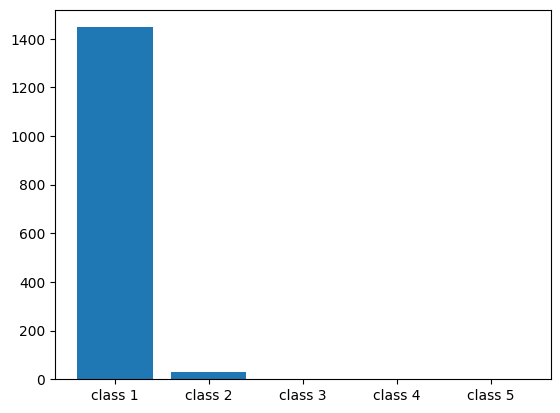

In [ ]:
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np

hist_values = []

for value in values:
  ctr = 0
  for item in precariousness_rate_fin:
    if item[1] == value:
      ctr = ctr + 1
  hist_values.append((value, ctr))

print(hist_values)

class1 = []
class2 = []
class3 = []
class4 = []
class5 = []

for item in hist_values:
  if item[0] > 80:
    class5.append(item)
  elif item[0] > 60 and item[0] <= 80:
    class4.append(item)
  elif item[0] > 40 and item[0] <= 60:
    class3.append(item)
  elif item[0] > 20 and item[0] <= 40:
    class2.append(item)
  else:
    class1.append(item)

class_hist = []

number_of_individuals_in_class1 = 0
for item in class1:
  number_of_individuals_in_class1 = number_of_individuals_in_class1 + item[1]

number_of_individuals_in_class2 = 0
for item in class2:
  number_of_individuals_in_class2 = number_of_individuals_in_class2 + item[1]

number_of_individuals_in_class3 = 0
for item in class3:
  number_of_individuals_in_class3 = number_of_individuals_in_class3 + item[1]

number_of_individuals_in_class4 = 0
for item in class4:
  number_of_individuals_in_class4 = number_of_individuals_in_class4 + item[1]

number_of_individuals_in_class5 = 0
for item in class5:
  number_of_individuals_in_class5 = number_of_individuals_in_class5 + item[1]

class_hist.append(("class 1", number_of_individuals_in_class1))
class_hist.append(("class 2", number_of_individuals_in_class2))
class_hist.append(("class 3", number_of_individuals_in_class3))
class_hist.append(("class 4", number_of_individuals_in_class4))
class_hist.append(("class 5", number_of_individuals_in_class5))

for i in range(len(class_hist)):
  print("Number of individuals in class", i+1, ":", class_hist[i][1])

print("\nHistogram:")

val, cnt = (zip(*class_hist))
val, cnt = list(val), list(cnt)
val, cnt

length = len(cnt)
plt.bar(np.arange(length), cnt, label=True)
plt.xticks(np.arange(len(cnt)), val)
plt.show()

In [ ]:
indicators = ["row_id", "ifrjob", "evfrjob", "netifr", "grspfr", "hincfel"]
data2_fin = pd.DataFrame()
data2_fin = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "FI")]
data2_fin = data2_fin[indicators]
data2_fin.head()

,row_id,ifrjob,evfrjob,netifr,grspfr,hincfel
18689,18689,6,7,-2,6,2
18690,18690,10,8,0,0,2
18691,18691,8,8,0,0,1
18692,18692,10,9,0,0,2
18693,18693,8,2,0,0,2


In [ ]:
data2_fin = data2_fin.to_numpy()

In [ ]:
precariousness_rate_sub_fin = []

for row in range(len(data2_fin)):
  sum = 0

  if data2_fin[row][1] == 0:
    sum = sum + 100
  elif data2_fin[row][1] == 1:
    sum = sum + 90
  elif data2_fin[row][1] == 2:
    sum = sum + 80
  elif data2_fin[row][1] == 3:
    sum = sum + 70
  elif data2_fin[row][1] == 4:
    sum = sum + 60
  elif data2_fin[row][1] == 5:
    sum = sum + 50
  elif data2_fin[row][1] == 6:
    sum = sum + 40
  elif data2_fin[row][1] == 7:
    sum = sum + 30
  elif data2_fin[row][1] == 8:
    sum = sum + 20
  elif data2_fin[row][1] == 9:
    sum = sum + 10

  if data2_fin[row][2] == 0:
    sum = sum + 100
  elif data2_fin[row][2] == 1:
    sum = sum + 90
  elif data2_fin[row][2] == 2:
    sum = sum + 80
  elif data2_fin[row][2] == 3:
    sum = sum + 70
  elif data2_fin[row][2] == 4:
    sum = sum + 60
  elif data2_fin[row][2] == 5:
    sum = sum + 50
  elif data2_fin[row][2] == 6:
    sum = sum + 40
  elif data2_fin[row][2] == 7:
    sum = sum + 30
  elif data2_fin[row][2] == 8:
    sum = sum + 20
  elif data2_fin[row][2] == 9:
    sum = sum + 10

  if data2_fin[row][3] == 4:
    sum = sum + 0
  elif data2_fin[row][3] == 3:
    sum = sum + 12.5
  elif data2_fin[row][3] == 2:
    sum = sum + 25
  elif data2_fin[row][3] == 1:
    sum = sum + 37.5
  elif data2_fin[row][3] == 0:
    sum = sum + 50
  elif data2_fin[row][3] == -1:
    sum = sum + 62.5
  elif data2_fin[row][3] == -2:
    sum = sum + 75
  elif data2_fin[row][3] == -3:
    sum = sum + 87.5
  elif data2_fin[row][3] == -4:
    sum = sum + 100

  if data2_fin[row][4] == 4:
    sum = sum + 0
  elif data2_fin[row][4] == 3:
    sum = sum + 12.5
  elif data2_fin[row][4] == 2:
    sum = sum + 25
  elif data2_fin[row][4] == 1:
    sum = sum + 37.5
  elif data2_fin[row][4] == 0:
    sum = sum + 50
  elif data2_fin[row][4] == -1:
    sum = sum + 62.5
  elif data2_fin[row][4] == -2:
    sum = sum + 75
  elif data2_fin[row][4] == -3:
    sum = sum + 87.5
  elif data2_fin[row][4] == -4:
    sum = sum + 100

  if data2_fin[row][5] == 2:
    sum = sum + 33.3
  elif data2_fin[row][5] == 3:
    sum = sum + 66.7
  elif data2_fin[row][5] == 4:
    sum = sum + 100

  score = sum/5

  precariousness_rate_sub_fin.append((int(data2_fin[row][0]), int(score)))

print("Precariousness Rate Tuples:")
print(precariousness_rate_sub_fin[0:40])
values = []
for item in precariousness_rate_sub_fin:
  if item[1] not in values:
    values.append(item[1])

values_sorted = values.copy()
values_sorted.sort()
print("\nPrecariousness Rate Values:")
print(values_sorted)

Precariousness Rate Tuples:
[(18689, 35), (18690, 30), (18691, 28), (18692, 28), (18693, 46), (18694, 31), (18695, 10), (18696, 30), (18697, 4), (18698, 22), (18699, 31), (18701, 26), (18702, 59), (18703, 30), (18704, 16), (18705, 42), (18706, 51), (18707, 33), (18709, 38), (18710, 40), (18711, 49), (18712, 31), (18713, 41), (18714, 38), (18715, 31), (18716, 38), (18717, 39), (18720, 16), (18721, 0), (18722, 30), (18723, 42), (18724, 44), (18725, 64), (18726, 30), (18727, 30), (18728, 44), (18729, 42), (18730, 50), (18731, 8), (18732, 52)]

Precariousness Rate Values:
[0, 2, 4, 6, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 82, 83, 91]


In [ ]:
mean_obj = np.mean(pr_fin)
mean_sub = np.mean(pr_sub_fin)

mini = min(pr_fin)
mini_sub = min(pr_sub_fin)

maxi = max(pr_fin)
maxi_sub = max(pr_sub_fin)

print(mean_obj)
print(mean_sub)
print()
print(mini)
print(mini_sub)
print()
print(maxi)
print(maxi_sub)

3.7000677048070414
37.29993229519296

0
0

53
91


####Socio-demographic Characteristics

#####Gender

In [ ]:
gender = ["row_id", "Gender"]
data_gender_fin = pd.DataFrame()
data_gender_fin = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "FI")]
data_gender_fin = data_gender_fin[gender]

data_gender_fin = data_gender_fin.to_numpy()

men_in_class1 = 0
women_in_class1 = 0
men_in_class2 = 0
women_in_class2 = 0
men_in_class3 = 0
women_in_class3 = 0
men_in_class4 = 0
women_in_class4 = 0
men_in_class5 = 0
women_in_class5 = 0

for i in range(len(data_gender_fin)):
  if precariousness_rate_fin[i][1] <= 20:
    if data_gender_fin[i][1] == 1:
      men_in_class1 = men_in_class1 + 1
    elif data_gender_fin[i][1] == 2:
      women_in_class1 = women_in_class1 + 1
  elif precariousness_rate_fin[i][1] > 20 and precariousness_rate_fin[i][1] <= 40:
    if data_gender_fin[i][1] == 1:
      men_in_class2 = men_in_class2 + 1
    elif data_gender_fin[i][1] == 2:
      women_in_class2 = women_in_class2 + 1
  elif precariousness_rate_fin[i][1] > 40 and precariousness_rate_fin[i][1] <= 60:
    if data_gender_fin[i][1] == 1:
      men_in_class3 = men_in_class3 + 1
    elif data_gender_fin[i][1] == 2:
      women_in_class3 = women_in_class3 + 1
  elif precariousness_rate_fin[i][1] > 60 and precariousness_rate_fin[i][1] <= 80:
    if data_gender_fin[i][1] == 1:
      men_in_class4 = men_in_class4 + 1
    elif data_gender_fin[i][1] == 2:
      women_in_class4 = women_in_class4 + 1
  else:
    if data_gender_fin[i][1] == 1:
      men_in_class5 = men_in_class5 + 1
    elif data_gender_fin[i][1] == 2:
      women_in_class5 = women_in_class5 + 1

print("Class 1:")
print("Number of men:", men_in_class1)
print("Number of women:", women_in_class1)
print("Percentage of men:", (men_in_class1 / (men_in_class1 + women_in_class1)) * 100)
print("Percentage of women:", (women_in_class1 / (men_in_class1 + women_in_class1)) * 100)
print(" ")

print("Class 2:")
print("Number of men:", men_in_class2)
print("Number of women:", women_in_class2)
print("Percentage of men:", (men_in_class2 / (men_in_class2 + women_in_class2)) * 100)
print("Percentage of women:", (women_in_class2 / (men_in_class2 + women_in_class2)) * 100)
print(" ")

print("Class 3:")
print("Number of men:", men_in_class3)
print("Number of women:", women_in_class3)
print("Percentage of men:", (men_in_class3 / (men_in_class3 + women_in_class3)) * 100)
print("Percentage of women:", (women_in_class3 / (men_in_class3 + women_in_class3)) * 100)
print(" ")

print("Class 4:")
print("Number of men:", men_in_class4)
print("Number of women:", women_in_class4)
#print("Percentage of men:", (men_in_class4 / (men_in_class4 + women_in_class4)) * 100)
#print("Percentage of women:", (women_in_class4 / (men_in_class4 + women_in_class4)) * 100)
print(" ")

print("Class 5:")
print("Number of men:", men_in_class5)
print("Number of women:", women_in_class5)
#print("Percentage of men:", (men_in_class5 / (men_in_class5 + women_in_class5)) * 100)
#print("Percentage of women:", (women_in_class5 / (men_in_class5 + women_in_class5)) * 100)

Class 1:
Number of men: 676
Number of women: 771
Percentage of men: 46.71734623358673
Percentage of women: 53.28265376641327
 
Class 2:
Number of men: 11
Number of women: 17
Percentage of men: 39.285714285714285
Percentage of women: 60.71428571428571
 
Class 3:
Number of men: 0
Number of women: 2
Percentage of men: 0.0
Percentage of women: 100.0
 
Class 4:
Number of men: 0
Number of women: 0
 
Class 5:
Number of men: 0
Number of women: 0


#####Mean Age

In [ ]:
age = ["row_id", "Age"]
data_age_fin = pd.DataFrame()
data_age_fin = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "FI")]
data_age_fin = data_age_fin[age]

data_age_fin = data_age_fin.to_numpy()

age_sum_in_class1 = 0
number_of_individuals_in_class1 = 0
age_sum_in_class2 = 0
number_of_individuals_in_class2 = 0
age_sum_in_class3 = 0
number_of_individuals_in_class3 = 0
age_sum_in_class4 = 0
number_of_individuals_in_class4 = 0
age_sum_in_class5 = 0
number_of_individuals_in_class5 = 0

for i in range(len(data_age_fin)):
  if precariousness_rate_fin[i][1] <= 20:
    age_sum_in_class1 = age_sum_in_class1 + data_age_fin[i][1]
    number_of_individuals_in_class1 = number_of_individuals_in_class1 + 1
  elif precariousness_rate_fin[i][1] > 20 and precariousness_rate_fin[i][1] <= 40:
    age_sum_in_class2 = age_sum_in_class2 + data_age_fin[i][1]
    number_of_individuals_in_class2 = number_of_individuals_in_class2 + 1
  elif precariousness_rate_fin[i][1] > 40 and precariousness_rate_fin[i][1] <= 60:
    age_sum_in_class3 = age_sum_in_class3 + data_age_fin[i][1]
    number_of_individuals_in_class3 = number_of_individuals_in_class3 + 1
  elif precariousness_rate_fin[i][1] > 60 and precariousness_rate_fin[i][1] <= 80:
    age_sum_in_class4 = age_sum_in_class4 + data_age_fin[i][1]
    number_of_individuals_in_class4 = number_of_individuals_in_class4 + 1
  else:
    age_sum_in_class5 = age_sum_in_class5 + data_age_fin[i][1]
    number_of_individuals_in_class5 = number_of_individuals_in_class5 + 1


print("mean age in Class 1:", age_sum_in_class1/number_of_individuals_in_class1)
print(" ")

print("mean age in Class 2:", age_sum_in_class2/number_of_individuals_in_class2)
print(" ")

print("mean age in Class 3:", age_sum_in_class3/number_of_individuals_in_class3)
print(" ")

print("mean age in Class 4: -")
print(" ")

print("mean age in Class 5: -")

mean age in Class 1: 51.08638562543193
 
mean age in Class 2: 44.25
 
mean age in Class 3: 36.0
 
mean age in Class 4: -
 
mean age in Class 5: -


#####Educational Level

In [ ]:
education = ["row_id", "education"]
data_education_fin = pd.DataFrame()
data_education_fin = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "FI")]
data_education_fin = data_education_fin[education]
data_education_fin["education"] = data_education_fin["education"].str.replace(',','.')

data_education_fin = data_education_fin.to_numpy()

ed1 = []
ed2 = []
ed3 = []
ed4 = []
ed5 = []


for i in range(4):
  ed1.append(0)
  ed2.append(0)
  ed3.append(0)
  ed4.append(0)
  ed5.append(0)


for i in range(len(data_education_fin)):
  if precariousness_rate_fin[i][1] <= 20:
    for j in range(4):
      if data_education_fin[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_fin[i][1])) == j:
          ed1[j] = ed1[j] + 1
  elif precariousness_rate_fin[i][1] > 20 and precariousness_rate_fin[i][1] <= 40:
    for j in range(4):
      if data_education_fin[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_fin[i][1])) == j:
          ed2[j] = ed2[j] + 1
  elif precariousness_rate_fin[i][1] > 40 and precariousness_rate_fin[i][1] <= 60:
    for j in range(4):
      if data_education_fin[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_fin[i][1])) == j:
          ed3[j] = ed3[j] + 1
  elif precariousness_rate_fin[i][1] > 60 and precariousness_rate_fin[i][1] <= 80:
    for j in range(4):
      if data_education_fin[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_fin[i][1])) == j:
          ed4[j] = ed4[j] + 1
  else:
    for j in range(4):
      if data_education_fin[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_fin[i][1])) == j:
          ed5[j] = ed5[j] + 1


print("Class 1:")
sum = 0
for i in range(4):
  sum = sum + ed1[i]
print("Percentage of low educated individuals:", (ed1[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed1[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed1[3]/ sum) * 100)
print(" ")

print("Class 2:")
sum = 0
for i in range(4):
  sum = sum + ed2[i]
print("Percentage of low educated individuals:", (ed2[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed2[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed2[3]/ sum) * 100)
print(" ")

print("Class 3:")
sum = 0
for i in range(4):
  sum = sum + ed3[i]
print("Percentage of low educated individuals:", (ed3[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed3[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed3[3]/ sum) * 100)
print(" ")

print("Class 4:")
sum = 0
for i in range(4):
  sum = sum + ed4[i]
#print("Percentage of low educated individuals:", (ed4[1]/ sum) * 100)
#print("Percentage of medium educated individuals:", (ed4[2]/ sum) * 100)
#print("Percentage of highly educated individuals:", (ed4[3]/ sum) * 100)
print(" ")

print("Class 5:")
sum = 0
for i in range(4):
  sum = sum + ed5[i]
#print("Percentage of low educated individuals:", (ed5[1]/ sum) * 100)
#print("Percentage of medium educated individuals:", (ed5[2]/ sum) * 100)
#print("Percentage of highly educated individuals:", (ed5[3]/ sum) * 100)

Class 1:
Percentage of low educated individuals: 16.90921690921691
Percentage of medium educated individuals: 50.03465003465003
Percentage of highly educated individuals: 33.056133056133056
 
Class 2:
Percentage of low educated individuals: 21.428571428571427
Percentage of medium educated individuals: 57.14285714285714
Percentage of highly educated individuals: 21.428571428571427
 
Class 3:
Percentage of low educated individuals: 0.0
Percentage of medium educated individuals: 50.0
Percentage of highly educated individuals: 50.0
 
Class 4:
 
Class 5:


#####Occupation

In [ ]:
occupation = ["row_id", "occupation"]
data_occupation_fin = pd.DataFrame()
data_occupation_fin = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "FI")]
data_occupation_fin = data_occupation_fin[occupation]
data_occupation_fin["occupation"] = data_occupation_fin["occupation"].str.replace(',','.')

data_occupation_fin = data_occupation_fin.to_numpy()

oc1 = []
oc2 = []
oc3 = []
oc4 = []
oc5 = []


for i in range(10):
  oc1.append(0)
  oc2.append(0)
  oc3.append(0)
  oc4.append(0)
  oc5.append(0)


for i in range(len(data_occupation_fin)):
  if precariousness_rate_fin[i][1] <= 20:
    for j in range(10):
      if data_occupation_fin[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_fin[i][1])) == j:
          oc1[j] = oc1[j] + 1
  elif precariousness_rate_fin[i][1] > 20 and precariousness_rate_fin[i][1] <= 40:
    for j in range(10):
      if data_occupation_fin[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_fin[i][1])) == j:
          oc2[j] = oc2[j] + 1
  elif precariousness_rate_fin[i][1] > 40 and precariousness_rate_fin[i][1] <= 60:
    for j in range(10):
      if data_occupation_fin[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_fin[i][1])) == j:
          oc3[j] = oc3[j] + 1
  elif precariousness_rate_fin[i][1] > 60 and precariousness_rate_fin[i][1] <= 80:
    for j in range(10):
      if data_occupation_fin[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_fin[i][1])) == j:
          oc4[j] = oc4[j] + 1
  else:
    for j in range(10):
      if data_occupation_fin[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_fin[i][1])) == j:
          oc5[j] = oc5[j] + 1


print("Class 1:")
sum = 0
for i in range(10):
  sum = sum + oc1[i]
print("Percentage of Armed Forces Occupations:", (oc1[0]/ sum) * 100)
print("Percentage of Managers:", (oc1[1]/ sum) * 100)
print("Percentage of Professionals:", (oc1[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc1[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc1[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc1[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc1[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc1[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc1[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc1[9]/ sum) * 100)
print(" ")

print("Class 2:")
sum = 0
for i in range(10):
  sum = sum + oc2[i]
print("Percentage of Armed Forces Occupations:", (oc2[0]/ sum) * 100)
print("Percentage of Managers:", (oc2[1]/ sum) * 100)
print("Percentage of Professionals:", (oc2[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc2[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc2[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc2[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc2[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc2[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc2[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc2[9]/ sum) * 100)
print(" ")

print("Class 3:")
sum = 0
for i in range(10):
  sum = sum + oc3[i]
print("Percentage of Armed Forces Occupations:", (oc3[0]/ sum) * 100)
print("Percentage of Managers:", (oc3[1]/ sum) * 100)
print("Percentage of Professionals:", (oc3[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc3[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc3[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc3[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc3[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc3[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc3[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc3[9]/ sum) * 100)
print(" ")

print("Class 4:")
sum = 0
for i in range(10):
  sum = sum + oc4[i]
#print("Percentage of Armed Forces Occupations:", (oc4[0]/ sum) * 100)
#print("Percentage of Managers:", (oc4[1]/ sum) * 100)
#print("Percentage of Professionals:", (oc4[2]/ sum) * 100)
#print("Percentage of Technicians and Associate Professionals:", (oc4[3]/ sum) * 100)
#print("Percentage of Clerical Support Workers:", (oc4[4]/ sum) * 100)
#print("Percentage of Service and Sales Workers:", (oc4[5]/ sum) * 100)
#print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc4[6]/ sum) * 100)
#print("Percentage of Craft and Related Trades Workers:", (oc4[7]/ sum) * 100)
#print("Percentage of Plant and Machine Operators, and Assemblers:", (oc4[8]/ sum) * 100)
#print("Percentage of Elementary Occupations:", (oc4[9]/ sum) * 100)
print(" ")

print("Class 5:")
sum = 0
for i in range(10):
  sum = sum + oc5[i]
#print("Percentage of Armed Forces Occupations:", (oc5[0]/ sum) * 100)
#print("Percentage of Managers:", (oc5[1]/ sum) * 100)
#print("Percentage of Professionals:", (oc5[2]/ sum) * 100)
#print("Percentage of Technicians and Associate Professionals:", (oc5[3]/ sum) * 100)
#print("Percentage of Clerical Support Workers:", (oc5[4]/ sum) * 100)
#print("Percentage of Service and Sales Workers:", (oc5[5]/ sum) * 100)
#print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc5[6]/ sum) * 100)
#print("Percentage of Craft and Related Trades Workers:", (oc5[7]/ sum) * 100)
#print("Percentage of Plant and Machine Operators, and Assemblers:", (oc5[8]/ sum) * 100)
#print("Percentage of Elementary Occupations:", (oc5[9]/ sum) * 100)

Class 1:
Percentage of Armed Forces Occupations: 0.41551246537396125
Percentage of Managers: 5.193905817174515
Percentage of Professionals: 23.407202216066484
Percentage of Technicians and Associate Professionals: 17.65927977839335
Percentage of Clerical Support Workers: 6.301939058171745
Percentage of Service and Sales Workers: 18.35180055401662
Percentage of Skilled Agricultural, Forestry and Fishery Workers: 1.5235457063711912
Percentage of Craft and Related Trades Workers: 11.634349030470915
Percentage of Plant and Machine Operators, and Assemblers: 7.132963988919667
Percentage of Elementary Occupations: 8.379501385041552
 
Class 2:
Percentage of Armed Forces Occupations: 0.0
Percentage of Managers: 0.0
Percentage of Professionals: 14.285714285714285
Percentage of Technicians and Associate Professionals: 14.285714285714285
Percentage of Clerical Support Workers: 0.0
Percentage of Service and Sales Workers: 28.57142857142857
Percentage of Skilled Agricultural, Forestry and Fishery W

#####Citizenship

In [ ]:
cit = ["row_id", "Citizen of country"]
data_cit_fin = pd.DataFrame()
data_cit_fin = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "FI")]
data_cit_fin = data_cit_fin[cit]

data_cit_fin = data_cit_fin.to_numpy()

number_of_citizens_of_country_in_class1 = 0
number_of_non_citizens_of_country_in_class1 = 0
number_of_citizens_of_country_in_class2 = 0
number_of_non_citizens_of_country_in_class2 = 0
number_of_citizens_of_country_in_class3 = 0
number_of_non_citizens_of_country_in_class3 = 0
number_of_citizens_of_country_in_class4 = 0
number_of_non_citizens_of_country_in_class4 = 0
number_of_citizens_of_country_in_class5 = 0
number_of_non_citizens_of_country_in_class5 = 0

for i in range(len(data_cit_fin)):
  if precariousness_rate_fin[i][1] <= 20:
    if data_cit_fin[i][1] == 1:
      number_of_citizens_of_country_in_class1 = number_of_citizens_of_country_in_class1 + 1
    elif data_cit_fin[i][1] == 2:
      number_of_non_citizens_of_country_in_class1 = number_of_non_citizens_of_country_in_class1 + 1
  elif precariousness_rate_fin[i][1] > 20 and precariousness_rate_fin[i][1] <= 40:
    if data_cit_fin[i][1] == 1:
      number_of_citizens_of_country_in_class2 = number_of_citizens_of_country_in_class2 + 1
    elif data_cit_fin[i][1] == 2:
      number_of_non_citizens_of_country_in_class2 = number_of_non_citizens_of_country_in_class2 + 1
  elif precariousness_rate_fin[i][1] > 40 and precariousness_rate_fin[i][1] <= 60:
    if data_cit_fin[i][1] == 1:
      number_of_citizens_of_country_in_class3 = number_of_citizens_of_country_in_class3 + 1
    elif data_cit_fin[i][1] == 2:
      number_of_non_citizens_of_country_in_class3 = number_of_non_citizens_of_country_in_class3 + 1
  elif precariousness_rate_fin[i][1] > 60 and precariousness_rate_fin[i][1] <= 80:
    if data_cit_fin[i][1] == 1:
      number_of_citizens_of_country_in_class4 = number_of_citizens_of_country_in_class4 + 1
    elif data_cit_fin[i][1] == 2:
      number_of_non_citizens_of_country_in_class4 = number_of_non_citizens_of_country_in_class4 + 1
  else:
    if data_cit_fin[i][1] == 1:
      number_of_citizens_of_country_in_class5 = number_of_citizens_of_country_in_class5 + 1
    elif data_cit_fin[i][1] == 2:
      number_of_non_citizens_of_country_in_class5 = number_of_non_citizens_of_country_in_class5 + 1

print("Class 1:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class1 / (number_of_citizens_of_country_in_class1 + number_of_non_citizens_of_country_in_class1)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class1 / (number_of_citizens_of_country_in_class1 + number_of_non_citizens_of_country_in_class1)) * 100)
print(" ")

print("Class 2:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class2 / (number_of_citizens_of_country_in_class2 + number_of_non_citizens_of_country_in_class2)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class2 / (number_of_citizens_of_country_in_class2 + number_of_non_citizens_of_country_in_class2)) * 100)
print(" ")

print("Class 3:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class3 / (number_of_citizens_of_country_in_class3 + number_of_non_citizens_of_country_in_class3)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class3 / (number_of_citizens_of_country_in_class3 + number_of_non_citizens_of_country_in_class3)) * 100)
print(" ")

print("Class 4:")
#print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class4 / (number_of_citizens_of_country_in_class4 + number_of_non_citizens_of_country_in_class4)) * 100)
#print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class4 / (number_of_citizens_of_country_in_class4 + number_of_non_citizens_of_country_in_class4)) * 100)
print(" ")

print("Class 5:")
#print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class5 / (number_of_citizens_of_country_in_class5 + number_of_non_citizens_of_country_in_class5)) * 100)
#print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class5 / (number_of_citizens_of_country_in_class5 + number_of_non_citizens_of_country_in_class5)) * 100)

Class 1:
Percentage of citizens of country: 98.34139599170697
Percentage of non citizens of country: 1.65860400829302
 
Class 2:
Percentage of citizens of country: 100.0
Percentage of non citizens of country: 0.0
 
Class 3:
Percentage of citizens of country: 100.0
Percentage of non citizens of country: 0.0
 
Class 4:
 
Class 5:


###The Case of Italy

####Implementation

In [ ]:
indicators = ["row_id", "HoursWorked", "EmploymentContract", "SetHours", "HouseholdsIncome", "netilet"]
data_it = pd.DataFrame()
data_it = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "IT")]
data_it = data_it[indicators]
data_it.head()

,row_id,HoursWorked,EmploymentContract,SetHours,HouseholdsIncome,netilet
31204,31204,32,2,1,2,66
31206,31206,36,1,1,77,2
31207,31207,15,1,1,77,77
31210,31210,25,2,1,77,77
31212,31212,30,1,1,77,77


In [ ]:
data_it = data_it.to_numpy()

In [ ]:
precariousness_rate_it = []

for row in range(len(data_it)):
  ScoreIE = 0
  if data_it[row][1] != "#ΚΕΝΟ!":
    if int(data_it[row][1]) <= 30:
      ScoreIE = ScoreIE + 35
  if data_it[row][2] == 2 or data_it[row][2] == 3:
    ScoreIE = ScoreIE + 35
  if data_it[row][3] == 2:
    ScoreIE = ScoreIE + 30
  ScoreUE = 0
  if data_it[row][2] == 3:
    ScoreUE = ScoreUE + 100
  ScoreIR = 0
  if data_it[row][4] <= 3:
    ScoreIR = ScoreIR + 40
  if data_it[row][5] <= 3:
    ScoreIR = ScoreIR + 60

  w1 = 1 + ScoreIE/100
  w2 = 1 + ScoreUE/100
  w3 = 1 + ScoreIR/100
  score = (w1*w2*w3 - 1) * 100 / 7
  precariousness_rate_it.append((int(data_it[row][0]), int(score)))

print("Precariousness Rate Tuples:")
print(precariousness_rate_it[0:40])

values = []
for item in precariousness_rate_it:
  if item[1] not in values:
    values.append(item[1])

values_sorted = values.copy()
values_sorted.sort()
print("\nPrecariousness Rate Values:")
print(values_sorted)

Precariousness Rate Tuples:
[(31204, 12), (31206, 8), (31207, 5), (31210, 10), (31212, 5), (31214, 5), (31215, 0), (31217, 5), (31219, 0), (31222, 0), (31223, 0), (31224, 5), (31225, 0), (31226, 0), (31228, 5), (31229, 0), (31232, 51), (31233, 0), (31234, 0), (31235, 0), (31240, 10), (31242, 0), (31246, 4), (31248, 5), (31251, 0), (31253, 0), (31255, 0), (31256, 5), (31257, 0), (31259, 0), (31262, 12), (31263, 0), (31264, 5), (31271, 0), (31272, 5), (31273, 0), (31276, 5), (31277, 14), (31280, 4), (31281, 5)]

Precariousness Rate Values:
[0, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 23, 24, 32, 34, 39, 47, 51, 53, 80]


[(12, 70), (8, 31), (5, 385), (10, 56), (0, 790), (51, 15), (4, 51), (14, 24), (19, 20), (32, 24), (9, 29), (24, 38), (39, 17), (34, 13), (80, 5), (15, 2), (53, 6), (23, 2), (16, 8), (18, 3), (47, 1), (11, 3)]
Number of individuals in class 1 : 1472
Number of individuals in class 2 : 94
Number of individuals in class 3 : 22
Number of individuals in class 4 : 5
Number of individuals in class 5 : 0

Histogram:


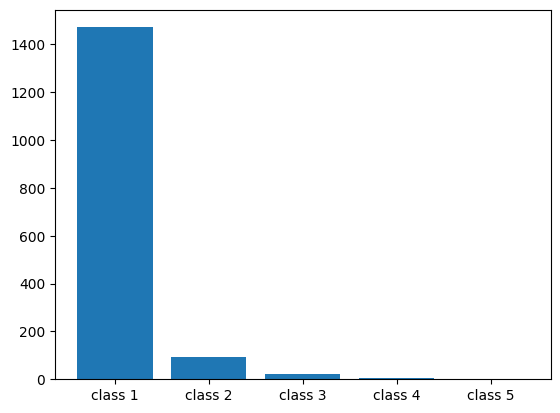

In [ ]:
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np

hist_values = []

for value in values:
  ctr = 0
  for item in precariousness_rate_it:
    if item[1] == value:
      ctr = ctr + 1
  hist_values.append((value, ctr))

print(hist_values)

class1 = []
class2 = []
class3 = []
class4 = []
class5 = []

for item in hist_values:
  if item[0] > 80:
    class5.append(item)
  elif item[0] > 60 and item[0] <= 80:
    class4.append(item)
  elif item[0] > 40 and item[0] <= 60:
    class3.append(item)
  elif item[0] > 20 and item[0] <= 40:
    class2.append(item)
  else:
    class1.append(item)

class_hist = []

number_of_individuals_in_class1 = 0
for item in class1:
  number_of_individuals_in_class1 = number_of_individuals_in_class1 + item[1]

number_of_individuals_in_class2 = 0
for item in class2:
  number_of_individuals_in_class2 = number_of_individuals_in_class2 + item[1]

number_of_individuals_in_class3 = 0
for item in class3:
  number_of_individuals_in_class3 = number_of_individuals_in_class3 + item[1]

number_of_individuals_in_class4 = 0
for item in class4:
  number_of_individuals_in_class4 = number_of_individuals_in_class4 + item[1]

number_of_individuals_in_class5 = 0
for item in class5:
  number_of_individuals_in_class5 = number_of_individuals_in_class5 + item[1]

class_hist.append(("class 1", number_of_individuals_in_class1))
class_hist.append(("class 2", number_of_individuals_in_class2))
class_hist.append(("class 3", number_of_individuals_in_class3))
class_hist.append(("class 4", number_of_individuals_in_class4))
class_hist.append(("class 5", number_of_individuals_in_class5))

for i in range(len(class_hist)):
  print("Number of individuals in class", i+1, ":", class_hist[i][1])

print("\nHistogram:")

val, cnt = (zip(*class_hist))
val, cnt = list(val), list(cnt)
val, cnt

length = len(cnt)
plt.bar(np.arange(length), cnt, label=True)
plt.xticks(np.arange(len(cnt)), val)
plt.show()

In [ ]:
indicators = ["row_id", "ifrjob", "evfrjob", "netifr", "grspfr", "hincfel"]
data2_it = pd.DataFrame()
data2_it = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "IT")]
data2_it = data2_it[indicators]
data2_it.head()

,row_id,ifrjob,evfrjob,netifr,grspfr,hincfel
31204,31204,6,5,6,6,2
31206,31206,6,2,-2,-2,1
31207,31207,7,3,-1,-1,1
31210,31210,7,7,-3,-3,3
31212,31212,8,1,-2,-3,2


In [ ]:
data2_it = data2_it.to_numpy()

In [ ]:
precariousness_rate_sub_it = []

for row in range(len(data2_it)):
  sum = 0

  if data2_it[row][1] == 0:
    sum = sum + 100
  elif data2_it[row][1] == 1:
    sum = sum + 90
  elif data2_it[row][1] == 2:
    sum = sum + 80
  elif data2_it[row][1] == 3:
    sum = sum + 70
  elif data2_it[row][1] == 4:
    sum = sum + 60
  elif data2_it[row][1] == 5:
    sum = sum + 50
  elif data2_it[row][1] == 6:
    sum = sum + 40
  elif data2_it[row][1] == 7:
    sum = sum + 30
  elif data2_it[row][1] == 8:
    sum = sum + 20
  elif data2_it[row][1] == 9:
    sum = sum + 10

  if data2_it[row][2] == 0:
    sum = sum + 100
  elif data2_it[row][2] == 1:
    sum = sum + 90
  elif data2_it[row][2] == 2:
    sum = sum + 80
  elif data2_it[row][2] == 3:
    sum = sum + 70
  elif data2_it[row][2] == 4:
    sum = sum + 60
  elif data2_it[row][2] == 5:
    sum = sum + 50
  elif data2_it[row][2] == 6:
    sum = sum + 40
  elif data2_it[row][2] == 7:
    sum = sum + 30
  elif data2_it[row][2] == 8:
    sum = sum + 20
  elif data2_it[row][2] == 9:
    sum = sum + 10

  if data2_it[row][3] == 4:
    sum = sum + 0
  elif data2_it[row][3] == 3:
    sum = sum + 12.5
  elif data2_it[row][3] == 2:
    sum = sum + 25
  elif data2_it[row][3] == 1:
    sum = sum + 37.5
  elif data2_it[row][3] == 0:
    sum = sum + 50
  elif data2_it[row][3] == -1:
    sum = sum + 62.5
  elif data2_it[row][3] == -2:
    sum = sum + 75
  elif data2_it[row][3] == -3:
    sum = sum + 87.5
  elif data2_it[row][3] == -4:
    sum = sum + 100

  if data2_it[row][4] == 4:
    sum = sum + 0
  elif data2_it[row][4] == 3:
    sum = sum + 12.5
  elif data2_it[row][4] == 2:
    sum = sum + 25
  elif data2_it[row][4] == 1:
    sum = sum + 37.5
  elif data2_it[row][4] == 0:
    sum = sum + 50
  elif data2_it[row][4] == -1:
    sum = sum + 62.5
  elif data2_it[row][4] == -2:
    sum = sum + 75
  elif data2_it[row][4] == -3:
    sum = sum + 87.5
  elif data2_it[row][4] == -4:
    sum = sum + 100

  if data2_it[row][5] == 2:
    sum = sum + 33.3
  elif data2_it[row][5] == 3:
    sum = sum + 66.7
  elif data2_it[row][5] == 4:
    sum = sum + 100

  score = sum/5

  precariousness_rate_sub_it.append((int(data2_it[row][0]), int(score)))

#precariousness_rate.sort(key=lambda tup: tup[1], reverse=True)
print("Precariousness Rate Tuples:")
print(precariousness_rate_sub_it[0:40])
values = []
for item in precariousness_rate_sub_it:
  if item[1] not in values:
    values.append(item[1])

values_sorted = values.copy()
values_sorted.sort()
print("\nPrecariousness Rate Values:")
print(values_sorted)

Precariousness Rate Tuples:
[(31204, 24), (31206, 54), (31207, 45), (31210, 60), (31212, 61), (31214, 60), (31215, 47), (31217, 70), (31219, 49), (31222, 37), (31223, 45), (31224, 40), (31225, 40), (31226, 40), (31228, 20), (31229, 38), (31232, 63), (31233, 30), (31234, 51), (31235, 39), (31240, 59), (31242, 45), (31246, 40), (31248, 51), (31251, 48), (31253, 34), (31255, 46), (31256, 49), (31257, 32), (31259, 36), (31262, 70), (31263, 35), (31264, 41), (31271, 41), (31272, 41), (31273, 30), (31276, 58), (31277, 21), (31280, 19), (31281, 44)]

Precariousness Rate Values:
[0, 6, 8, 10, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 92, 93, 95, 97, 98, 100]


In [ ]:
mean_obj = np.mean(pr_it)
mean_sub = np.mean(pr_sub_it)

mini = min(pr_it)
mini_sub = min(pr_sub_it)

maxi = max(pr_it)
maxi_sub = max(pr_sub_it)

print(mean_obj)
print(mean_sub)
print()
print(mini)
print(mini_sub)
print()
print(maxi)
print(maxi_sub)

5.875706214689266
47.14752040175769

0
0

80
100


####Socio-demographic Characteristics

#####Gender

In [ ]:
gender = ["row_id", "Gender"]
data_gender_it = pd.DataFrame()
data_gender_it = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "IT")]
data_gender_it = data_gender_it[gender]

data_gender_it = data_gender_it.to_numpy()

men_in_class1 = 0
women_in_class1 = 0
men_in_class2 = 0
women_in_class2 = 0
men_in_class3 = 0
women_in_class3 = 0
men_in_class4 = 0
women_in_class4 = 0
men_in_class5 = 0
women_in_class5 = 0

for i in range(len(data_gender_it)):
  if precariousness_rate_it[i][1] <= 20:
    if data_gender_it[i][1] == 1:
      men_in_class1 = men_in_class1 + 1
    elif data_gender_it[i][1] == 2:
      women_in_class1 = women_in_class1 + 1
  elif precariousness_rate_it[i][1] > 20 and precariousness_rate_it[i][1] <= 40:
    if data_gender_it[i][1] == 1:
      men_in_class2 = men_in_class2 + 1
    elif data_gender_it[i][1] == 2:
      women_in_class2 = women_in_class2 + 1
  elif precariousness_rate_it[i][1] > 40 and precariousness_rate_it[i][1] <= 60:
    if data_gender_it[i][1] == 1:
      men_in_class3 = men_in_class3 + 1
    elif data_gender_it[i][1] == 2:
      women_in_class3 = women_in_class3 + 1
  elif precariousness_rate_it[i][1] > 60 and precariousness_rate_it[i][1] <= 80:
    if data_gender_it[i][1] == 1:
      men_in_class4 = men_in_class4 + 1
    elif data_gender_it[i][1] == 2:
      women_in_class4 = women_in_class4 + 1
  else:
    if data_gender_it[i][1] == 1:
      men_in_class5 = men_in_class5 + 1
    elif data_gender_it[i][1] == 2:
      women_in_class5 = women_in_class5 + 1

print("Class 1:")
print("Number of men:", men_in_class1)
print("Number of women:", women_in_class1)
print("Percentage of men:", (men_in_class1 / (men_in_class1 + women_in_class1)) * 100)
print("Percentage of women:", (women_in_class1 / (men_in_class1 + women_in_class1)) * 100)
print(" ")

print("Class 2:")
print("Number of men:", men_in_class2)
print("Number of women:", women_in_class2)
print("Percentage of men:", (men_in_class2 / (men_in_class2 + women_in_class2)) * 100)
print("Percentage of women:", (women_in_class2 / (men_in_class2 + women_in_class2)) * 100)
print(" ")

print("Class 3:")
print("Number of men:", men_in_class3)
print("Number of women:", women_in_class3)
print("Percentage of men:", (men_in_class3 / (men_in_class3 + women_in_class3)) * 100)
print("Percentage of women:", (women_in_class3 / (men_in_class3 + women_in_class3)) * 100)
print(" ")

print("Class 4:")
print("Number of men:", men_in_class4)
print("Number of women:", women_in_class4)
print("Percentage of men:", (men_in_class4 / (men_in_class4 + women_in_class4)) * 100)
print("Percentage of women:", (women_in_class4 / (men_in_class4 + women_in_class4)) * 100)
print(" ")

print("Class 5:")
print("Number of men:", men_in_class5)
print("Number of women:", women_in_class5)
#print("Percentage of men:", (men_in_class5 / (men_in_class5 + women_in_class5)) * 100)
#print("Percentage of women:", (women_in_class5 / (men_in_class5 + women_in_class5)) * 100)

Class 1:
Number of men: 741
Number of women: 731
Percentage of men: 50.339673913043484
Percentage of women: 49.66032608695652
 
Class 2:
Number of men: 44
Number of women: 50
Percentage of men: 46.808510638297875
Percentage of women: 53.191489361702125
 
Class 3:
Number of men: 9
Number of women: 13
Percentage of men: 40.909090909090914
Percentage of women: 59.09090909090909
 
Class 4:
Number of men: 5
Number of women: 0
Percentage of men: 100.0
Percentage of women: 0.0
 
Class 5:
Number of men: 0
Number of women: 0


#####Mean Age

In [ ]:
age = ["row_id", "Age"]
data_age_it = pd.DataFrame()
data_age_it = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "IT")]
data_age_it = data_age_it[age]

data_age_it = data_age_it.to_numpy()

age_sum_in_class1 = 0
number_of_individuals_in_class1 = 0
age_sum_in_class2 = 0
number_of_individuals_in_class2 = 0
age_sum_in_class3 = 0
number_of_individuals_in_class3 = 0
age_sum_in_class4 = 0
number_of_individuals_in_class4 = 0
age_sum_in_class5 = 0
number_of_individuals_in_class5 = 0

for i in range(len(data_age_it)):
  if precariousness_rate_it[i][1] <= 20:
    age_sum_in_class1 = age_sum_in_class1 + data_age_it[i][1]
    number_of_individuals_in_class1 = number_of_individuals_in_class1 + 1
  elif precariousness_rate_it[i][1] > 20 and precariousness_rate_it[i][1] <= 40:
    age_sum_in_class2 = age_sum_in_class2 + data_age_it[i][1]
    number_of_individuals_in_class2 = number_of_individuals_in_class2 + 1
  elif precariousness_rate_it[i][1] > 40 and precariousness_rate_it[i][1] <= 60:
    age_sum_in_class3 = age_sum_in_class3 + data_age_it[i][1]
    number_of_individuals_in_class3 = number_of_individuals_in_class3 + 1
  elif precariousness_rate_it[i][1] > 60 and precariousness_rate_it[i][1] <= 80:
    age_sum_in_class4 = age_sum_in_class4 + data_age_it[i][1]
    number_of_individuals_in_class4 = number_of_individuals_in_class4 + 1
  else:
    age_sum_in_class5 = age_sum_in_class5 + data_age_it[i][1]
    number_of_individuals_in_class5 = number_of_individuals_in_class5 + 1


print("mean age in Class 1:", age_sum_in_class1/number_of_individuals_in_class1)
print(" ")

print("mean age in Class 2:", age_sum_in_class2/number_of_individuals_in_class2)
print(" ")

print("mean age in Class 3:", age_sum_in_class3/number_of_individuals_in_class3)
print(" ")

print("mean age in Class 4:", age_sum_in_class4/number_of_individuals_in_class4)
print(" ")

print("mean age in Class 5: -")

mean age in Class 1: 57.92798913043478
 
mean age in Class 2: 47.51063829787234
 
mean age in Class 3: 140.45454545454547
 
mean age in Class 4: 43.8
 
mean age in Class 5: -


#####Educational Level

In [ ]:
education = ["row_id", "education"]
data_education_it = pd.DataFrame()
data_education_it = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "IT")]
data_education_it = data_education_it[education]
data_education_it["education"] = data_education_it["education"].str.replace(',','.')

data_education_it = data_education_it.to_numpy()

ed1 = []
ed2 = []
ed3 = []
ed4 = []
ed5 = []


for i in range(4):
  ed1.append(0)
  ed2.append(0)
  ed3.append(0)
  ed4.append(0)
  ed5.append(0)


for i in range(len(data_education_it)):
  if precariousness_rate_it[i][1] <= 20:
    for j in range(4):
      if data_education_it[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_it[i][1])) == j:
          ed1[j] = ed1[j] + 1
  elif precariousness_rate_it[i][1] > 20 and precariousness_rate_it[i][1] <= 40:
    for j in range(4):
      if data_education_it[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_it[i][1])) == j:
          ed2[j] = ed2[j] + 1
  elif precariousness_rate_it[i][1] > 40 and precariousness_rate_it[i][1] <= 60:
    for j in range(4):
      if data_education_it[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_it[i][1])) == j:
          ed3[j] = ed3[j] + 1
  elif precariousness_rate_it[i][1] > 60 and precariousness_rate_it[i][1] <= 80:
    for j in range(4):
      if data_education_it[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_it[i][1])) == j:
          ed4[j] = ed4[j] + 1
  else:
    for j in range(4):
      if data_education_it[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_it[i][1])) == j:
          ed5[j] = ed5[j] + 1


print("Class 1:")
sum = 0
for i in range(4):
  sum = sum + ed1[i]
print("Percentage of low educated individuals:", (ed1[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed1[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed1[3]/ sum) * 100)
print(" ")

print("Class 2:")
sum = 0
for i in range(4):
  sum = sum + ed2[i]
print("Percentage of low educated individuals:", (ed2[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed2[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed2[3]/ sum) * 100)
print(" ")

print("Class 3:")
sum = 0
for i in range(4):
  sum = sum + ed3[i]
print("Percentage of low educated individuals:", (ed3[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed3[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed3[3]/ sum) * 100)
print(" ")

print("Class 4:")
sum = 0
for i in range(4):
  sum = sum + ed4[i]
print("Percentage of low educated individuals:", (ed4[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed4[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed4[3]/ sum) * 100)
print(" ")

print("Class 5:")
sum = 0
for i in range(4):
  sum = sum + ed5[i]
#print("Percentage of low educated individuals:", (ed5[1]/ sum) * 100)
#print("Percentage of medium educated individuals:", (ed5[2]/ sum) * 100)
#print("Percentage of highly educated individuals:", (ed5[3]/ sum) * 100)

Class 1:
Percentage of low educated individuals: 39.302802460697194
Percentage of medium educated individuals: 44.83937115516063
Percentage of highly educated individuals: 15.857826384142173
 
Class 2:
Percentage of low educated individuals: 61.29032258064516
Percentage of medium educated individuals: 33.33333333333333
Percentage of highly educated individuals: 5.376344086021505
 
Class 3:
Percentage of low educated individuals: 59.09090909090909
Percentage of medium educated individuals: 27.27272727272727
Percentage of highly educated individuals: 13.636363636363635
 
Class 4:
Percentage of low educated individuals: 80.0
Percentage of medium educated individuals: 20.0
Percentage of highly educated individuals: 0.0
 
Class 5:


#####Occupation

In [ ]:
occupation = ["row_id", "occupation"]
data_occupation_it = pd.DataFrame()
data_occupation_it = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "IT")]
data_occupation_it = data_occupation_it[occupation]
data_occupation_it["occupation"] = data_occupation_it["occupation"].str.replace(',','.')

data_occupation_it = data_occupation_it.to_numpy()

oc1 = []
oc2 = []
oc3 = []
oc4 = []
oc5 = []


for i in range(10):
  oc1.append(0)
  oc2.append(0)
  oc3.append(0)
  oc4.append(0)
  oc5.append(0)


for i in range(len(data_occupation_it)):
  if precariousness_rate_it[i][1] <= 20:
    for j in range(10):
      if data_occupation_it[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_it[i][1])) == j:
          oc1[j] = oc1[j] + 1
  elif precariousness_rate_it[i][1] > 20 and precariousness_rate_it[i][1] <= 40:
    for j in range(10):
      if data_occupation_it[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_it[i][1])) == j:
          oc2[j] = oc2[j] + 1
  elif precariousness_rate_it[i][1] > 40 and precariousness_rate_it[i][1] <= 60:
    for j in range(10):
      if data_occupation_it[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_it[i][1])) == j:
          oc3[j] = oc3[j] + 1
  elif precariousness_rate_it[i][1] > 60 and precariousness_rate_it[i][1] <= 80:
    for j in range(10):
      if data_occupation_it[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_it[i][1])) == j:
          oc4[j] = oc4[j] + 1
  else:
    for j in range(10):
      if data_occupation_it[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_it[i][1])) == j:
          oc5[j] = oc5[j] + 1


print("Class 1:")
sum = 0
for i in range(10):
  sum = sum + oc1[i]
print("Percentage of Armed Forces Occupations:", (oc1[0]/ sum) * 100)
print("Percentage of Managers:", (oc1[1]/ sum) * 100)
print("Percentage of Professionals:", (oc1[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc1[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc1[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc1[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc1[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc1[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc1[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc1[9]/ sum) * 100)
print(" ")

print("Class 2:")
sum = 0
for i in range(10):
  sum = sum + oc2[i]
print("Percentage of Armed Forces Occupations:", (oc2[0]/ sum) * 100)
print("Percentage of Managers:", (oc2[1]/ sum) * 100)
print("Percentage of Professionals:", (oc2[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc2[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc2[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc2[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc2[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc2[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc2[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc2[9]/ sum) * 100)
print(" ")

print("Class 3:")
sum = 0
for i in range(10):
  sum = sum + oc3[i]
print("Percentage of Armed Forces Occupations:", (oc3[0]/ sum) * 100)
print("Percentage of Managers:", (oc3[1]/ sum) * 100)
print("Percentage of Professionals:", (oc3[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc3[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc3[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc3[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc3[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc3[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc3[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc3[9]/ sum) * 100)
print(" ")

print("Class 4:")
sum = 0
for i in range(10):
  sum = sum + oc4[i]
print("Percentage of Armed Forces Occupations:", (oc4[0]/ sum) * 100)
print("Percentage of Managers:", (oc4[1]/ sum) * 100)
print("Percentage of Professionals:", (oc4[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc4[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc4[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc4[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc4[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc4[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc4[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc4[9]/ sum) * 100)
print(" ")

print("Class 5:")
sum = 0
for i in range(10):
  sum = sum + oc5[i]
#print("Percentage of Armed Forces Occupations:", (oc5[0]/ sum) * 100)
#print("Percentage of Managers:", (oc5[1]/ sum) * 100)
#print("Percentage of Professionals:", (oc5[2]/ sum) * 100)
#print("Percentage of Technicians and Associate Professionals:", (oc5[3]/ sum) * 100)
#print("Percentage of Clerical Support Workers:", (oc5[4]/ sum) * 100)
#print("Percentage of Service and Sales Workers:", (oc5[5]/ sum) * 100)
#print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc5[6]/ sum) * 100)
#print("Percentage of Craft and Related Trades Workers:", (oc5[7]/ sum) * 100)
#print("Percentage of Plant and Machine Operators, and Assemblers:", (oc5[8]/ sum) * 100)
#print("Percentage of Elementary Occupations:", (oc5[9]/ sum) * 100)

Class 1:
Percentage of Armed Forces Occupations: 0.7529089664613279
Percentage of Managers: 2.0533880903490758
Percentage of Professionals: 13.483915126625599
Percentage of Technicians and Associate Professionals: 17.522245037645447
Percentage of Clerical Support Workers: 11.498973305954825
Percentage of Service and Sales Workers: 16.97467488021903
Percentage of Skilled Agricultural, Forestry and Fishery Workers: 0.8898015058179329
Percentage of Craft and Related Trades Workers: 14.715947980835045
Percentage of Plant and Machine Operators, and Assemblers: 7.802874743326489
Percentage of Elementary Occupations: 14.30527036276523
 
Class 2:
Percentage of Armed Forces Occupations: 0.0
Percentage of Managers: 1.0752688172043012
Percentage of Professionals: 3.225806451612903
Percentage of Technicians and Associate Professionals: 3.225806451612903
Percentage of Clerical Support Workers: 2.1505376344086025
Percentage of Service and Sales Workers: 24.731182795698924
Percentage of Skilled Agric

#####Citizenship

In [ ]:
cit = ["row_id", "Citizen of country"]
data_cit_it = pd.DataFrame()
data_cit_it = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "IT")]
data_cit_it = data_cit_it[cit]

data_cit_it = data_cit_it.to_numpy()

number_of_citizens_of_country_in_class1 = 0
number_of_non_citizens_of_country_in_class1 = 0
number_of_citizens_of_country_in_class2 = 0
number_of_non_citizens_of_country_in_class2 = 0
number_of_citizens_of_country_in_class3 = 0
number_of_non_citizens_of_country_in_class3 = 0
number_of_citizens_of_country_in_class4 = 0
number_of_non_citizens_of_country_in_class4 = 0
number_of_citizens_of_country_in_class5 = 0
number_of_non_citizens_of_country_in_class5 = 0

for i in range(len(data_cit_it)):
  if precariousness_rate_it[i][1] <= 20:
    if data_cit_it[i][1] == 1:
      number_of_citizens_of_country_in_class1 = number_of_citizens_of_country_in_class1 + 1
    elif data_cit_it[i][1] == 2:
      number_of_non_citizens_of_country_in_class1 = number_of_non_citizens_of_country_in_class1 + 1
  elif precariousness_rate_it[i][1] > 20 and precariousness_rate_it[i][1] <= 40:
    if data_cit_it[i][1] == 1:
      number_of_citizens_of_country_in_class2 = number_of_citizens_of_country_in_class2 + 1
    elif data_cit_it[i][1] == 2:
      number_of_non_citizens_of_country_in_class2 = number_of_non_citizens_of_country_in_class2 + 1
  elif precariousness_rate_it[i][1] > 40 and precariousness_rate_it[i][1] <= 60:
    if data_cit_it[i][1] == 1:
      number_of_citizens_of_country_in_class3 = number_of_citizens_of_country_in_class3 + 1
    elif data_cit_it[i][1] == 2:
      number_of_non_citizens_of_country_in_class3 = number_of_non_citizens_of_country_in_class3 + 1
  elif precariousness_rate_it[i][1] > 60 and precariousness_rate_it[i][1] <= 80:
    if data_cit_it[i][1] == 1:
      number_of_citizens_of_country_in_class4 = number_of_citizens_of_country_in_class4 + 1
    elif data_cit_it[i][1] == 2:
      number_of_non_citizens_of_country_in_class4 = number_of_non_citizens_of_country_in_class4 + 1
  else:
    if data_cit_it[i][1] == 1:
      number_of_citizens_of_country_in_class5 = number_of_citizens_of_country_in_class5 + 1
    elif data_cit_it[i][1] == 2:
      number_of_non_citizens_of_country_in_class5 = number_of_non_citizens_of_country_in_class5 + 1

print("Class 1:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class1 / (number_of_citizens_of_country_in_class1 + number_of_non_citizens_of_country_in_class1)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class1 / (number_of_citizens_of_country_in_class1 + number_of_non_citizens_of_country_in_class1)) * 100)
print(" ")

print("Class 2:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class2 / (number_of_citizens_of_country_in_class2 + number_of_non_citizens_of_country_in_class2)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class2 / (number_of_citizens_of_country_in_class2 + number_of_non_citizens_of_country_in_class2)) * 100)
print(" ")

print("Class 3:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class3 / (number_of_citizens_of_country_in_class3 + number_of_non_citizens_of_country_in_class3)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class3 / (number_of_citizens_of_country_in_class3 + number_of_non_citizens_of_country_in_class3)) * 100)
print(" ")

print("Class 4:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class4 / (number_of_citizens_of_country_in_class4 + number_of_non_citizens_of_country_in_class4)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class4 / (number_of_citizens_of_country_in_class4 + number_of_non_citizens_of_country_in_class4)) * 100)
print(" ")

print("Class 5:")
#print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class5 / (number_of_citizens_of_country_in_class5 + number_of_non_citizens_of_country_in_class5)) * 100)
#print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class5 / (number_of_citizens_of_country_in_class5 + number_of_non_citizens_of_country_in_class5)) * 100)

Class 1:
Percentage of citizens of country: 94.27792915531336
Percentage of non citizens of country: 5.722070844686648
 
Class 2:
Percentage of citizens of country: 82.97872340425532
Percentage of non citizens of country: 17.02127659574468
 
Class 3:
Percentage of citizens of country: 72.72727272727273
Percentage of non citizens of country: 27.27272727272727
 
Class 4:
Percentage of citizens of country: 100.0
Percentage of non citizens of country: 0.0
 
Class 5:


###The Case of Lithuania

####Implementation

In [ ]:
indicators = ["row_id", "HoursWorked", "EmploymentContract", "SetHours", "HouseholdsIncome", "netilet"]
data_lith = pd.DataFrame()
data_lith = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "LT")]
data_lith = data_lith[indicators]
data_lith.head()

,row_id,HoursWorked,EmploymentContract,SetHours,HouseholdsIncome,netilet
33949,33949,666,1,2,2,66
33950,33950,666,2,2,1,88
33951,33951,40,1,1,4,66
33952,33952,40,1,1,1,66
33953,33953,40,1,1,2,66


In [ ]:
data_lith = data_lith.to_numpy()

In [ ]:
precariousness_rate_lith = []

for row in range(len(data_lith)):
  ScoreIE = 0
  if data_lith[row][1] != "#ΚΕΝΟ!":
    if int(data_lith[row][1]) <= 30:
      ScoreIE = ScoreIE + 35
  if data_lith[row][2] == 2 or data_lith[row][2] == 3:
    ScoreIE = ScoreIE + 35
  if data_lith[row][3] == 2:
    ScoreIE = ScoreIE + 30
  ScoreUE = 0
  if data_lith[row][2] == 3:
    ScoreUE = ScoreUE + 100
  ScoreIR = 0
  if data_lith[row][4] <= 3:
    ScoreIR = ScoreIR + 40
  if data_lith[row][5] <= 3:
    ScoreIR = ScoreIR + 60

  w1 = 1 + ScoreIE/100
  w2 = 1 + ScoreUE/100
  w3 = 1 + ScoreIR/100
  score = (w1*w2*w3 - 1) * 100 / 7
  precariousness_rate_lith.append((int(data_lith[row][0]), int(score)))

print("Precariousness Rate Tuples:")
print(precariousness_rate_lith[0:40])

values = []
for item in precariousness_rate_lith:
  if item[1] not in values:
    values.append(item[1])

values_sorted = values.copy()
values_sorted.sort()
print("\nPrecariousness Rate Values:")
print(values_sorted)

Precariousness Rate Tuples:
[(33949, 11), (33950, 18), (33951, 0), (33952, 5), (33953, 5), (33954, 0), (33955, 5), (33957, 0), (33958, 0), (33959, 0), (33960, 11), (33961, 0), (33962, 0), (33963, 12), (33965, 0), (33966, 5), (33967, 5), (33968, 0), (33969, 0), (33971, 0), (33972, 5), (33973, 5), (33974, 5), (33975, 0), (33976, 0), (33977, 0), (33978, 4), (33979, 5), (33980, 5), (33982, 39), (33985, 18), (33986, 12), (33987, 11), (33988, 5), (33989, 0), (33990, 0), (33991, 5), (33992, 5), (33993, 5), (33995, 11)]

Precariousness Rate Values:
[0, 4, 5, 8, 9, 10, 11, 12, 14, 16, 18, 19, 22, 24, 32, 39, 51, 53]


[(11, 55), (18, 9), (0, 723), (5, 635), (12, 71), (4, 25), (39, 3), (19, 7), (8, 17), (16, 2), (14, 25), (22, 2), (10, 8), (9, 6), (24, 7), (51, 2), (32, 4), (53, 1)]
Number of individuals in class 1 : 1583
Number of individuals in class 2 : 16
Number of individuals in class 3 : 3
Number of individuals in class 4 : 0
Number of individuals in class 5 : 0

Histogram:


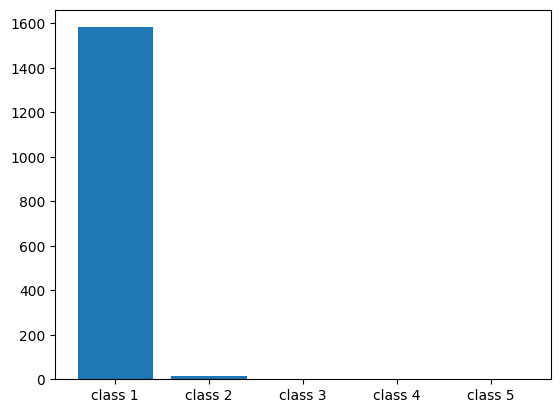

In [ ]:
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np

hist_values = []

for value in values:
  ctr = 0
  for item in precariousness_rate_lith:
    if item[1] == value:
      ctr = ctr + 1
  hist_values.append((value, ctr))

print(hist_values)

class1 = []
class2 = []
class3 = []
class4 = []
class5 = []

for item in hist_values:
  if item[0] > 80:
    class5.append(item)
  elif item[0] > 60 and item[0] <= 80:
    class4.append(item)
  elif item[0] > 40 and item[0] <= 60:
    class3.append(item)
  elif item[0] > 20 and item[0] <= 40:
    class2.append(item)
  else:
    class1.append(item)

class_hist = []

number_of_individuals_in_class1 = 0
for item in class1:
  number_of_individuals_in_class1 = number_of_individuals_in_class1 + item[1]

number_of_individuals_in_class2 = 0
for item in class2:
  number_of_individuals_in_class2 = number_of_individuals_in_class2 + item[1]

number_of_individuals_in_class3 = 0
for item in class3:
  number_of_individuals_in_class3 = number_of_individuals_in_class3 + item[1]

number_of_individuals_in_class4 = 0
for item in class4:
  number_of_individuals_in_class4 = number_of_individuals_in_class4 + item[1]

number_of_individuals_in_class5 = 0
for item in class5:
  number_of_individuals_in_class5 = number_of_individuals_in_class5 + item[1]

class_hist.append(("class 1", number_of_individuals_in_class1))
class_hist.append(("class 2", number_of_individuals_in_class2))
class_hist.append(("class 3", number_of_individuals_in_class3))
class_hist.append(("class 4", number_of_individuals_in_class4))
class_hist.append(("class 5", number_of_individuals_in_class5))

for i in range(len(class_hist)):
  print("Number of individuals in class", i+1, ":", class_hist[i][1])

print("\nHistogram:")

val, cnt = (zip(*class_hist))
val, cnt = list(val), list(cnt)
val, cnt

length = len(cnt)
plt.bar(np.arange(length), cnt, label=True)
plt.xticks(np.arange(len(cnt)), val)
plt.show()

In [ ]:
indicators = ["row_id", "ifrjob", "evfrjob", "netifr", "grspfr", "hincfel"]
data2_lith = pd.DataFrame()
data2_lith = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "LT")]
data2_lith = data2_lith[indicators]
data2_lith.head()

,row_id,ifrjob,evfrjob,netifr,grspfr,hincfel
33949,33949,5,5,-3,6,3
33950,33950,2,3,-4,-4,3
33951,33951,5,8,-3,-3,3
33952,33952,5,0,-4,6,3
33953,33953,6,6,-1,6,1


In [ ]:
data2_lith = data2_lith.to_numpy()

In [ ]:
precariousness_rate_sub_lith = []

for row in range(len(data2_lith)):
  sum = 0

  if data2_lith[row][1] == 0:
    sum = sum + 100
  elif data2_lith[row][1] == 1:
    sum = sum + 90
  elif data2_lith[row][1] == 2:
    sum = sum + 80
  elif data2_lith[row][1] == 3:
    sum = sum + 70
  elif data2_lith[row][1] == 4:
    sum = sum + 60
  elif data2_lith[row][1] == 5:
    sum = sum + 50
  elif data2_lith[row][1] == 6:
    sum = sum + 40
  elif data2_lith[row][1] == 7:
    sum = sum + 30
  elif data2_lith[row][1] == 8:
    sum = sum + 20
  elif data2_lith[row][1] == 9:
    sum = sum + 10

  if data2_lith[row][2] == 0:
    sum = sum + 100
  elif data2_lith[row][2] == 1:
    sum = sum + 90
  elif data2_lith[row][2] == 2:
    sum = sum + 80
  elif data2_lith[row][2] == 3:
    sum = sum + 70
  elif data2_lith[row][2] == 4:
    sum = sum + 60
  elif data2_lith[row][2] == 5:
    sum = sum + 50
  elif data2_lith[row][2] == 6:
    sum = sum + 40
  elif data2_lith[row][2] == 7:
    sum = sum + 30
  elif data2_lith[row][2] == 8:
    sum = sum + 20
  elif data2_lith[row][2] == 9:
    sum = sum + 10

  if data2_lith[row][3] == 4:
    sum = sum + 0
  elif data2_lith[row][3] == 3:
    sum = sum + 12.5
  elif data2_lith[row][3] == 2:
    sum = sum + 25
  elif data2_lith[row][3] == 1:
    sum = sum + 37.5
  elif data2_lith[row][3] == 0:
    sum = sum + 50
  elif data2_lith[row][3] == -1:
    sum = sum + 62.5
  elif data2_lith[row][3] == -2:
    sum = sum + 75
  elif data2_lith[row][3] == -3:
    sum = sum + 87.5
  elif data2_lith[row][3] == -4:
    sum = sum + 100

  if data2_lith[row][4] == 4:
    sum = sum + 0
  elif data2_lith[row][4] == 3:
    sum = sum + 12.5
  elif data2_lith[row][4] == 2:
    sum = sum + 25
  elif data2_lith[row][4] == 1:
    sum = sum + 37.5
  elif data2_lith[row][4] == 0:
    sum = sum + 50
  elif data2_lith[row][4] == -1:
    sum = sum + 62.5
  elif data2_lith[row][4] == -2:
    sum = sum + 75
  elif data2_lith[row][4] == -3:
    sum = sum + 87.5
  elif data2_lith[row][4] == -4:
    sum = sum + 100

  if data2_lith[row][5] == 2:
    sum = sum + 33.3
  elif data2_lith[row][5] == 3:
    sum = sum + 66.7
  elif data2_lith[row][5] == 4:
    sum = sum + 100

  score = sum/5

  precariousness_rate_sub_lith.append((int(data2_lith[row][0]), int(score)))

#precariousness_rate.sort(key=lambda tup: tup[1], reverse=True)
print("Precariousness Rate Tuples:")
print(precariousness_rate_sub_lith[0:40])
values = []
for item in precariousness_rate_sub_lith:
  if item[1] not in values:
    values.append(item[1])

values_sorted = values.copy()
values_sorted.sort()
print("\nPrecariousness Rate Values:")
print(values_sorted)

Precariousness Rate Tuples:
[(33949, 50), (33950, 83), (33951, 62), (33952, 63), (33953, 28), (33954, 45), (33955, 51), (33957, 50), (33958, 41), (33959, 41), (33960, 59), (33961, 60), (33962, 76), (33963, 68), (33965, 68), (33966, 55), (33967, 80), (33968, 26), (33969, 27), (33971, 37), (33972, 36), (33973, 66), (33974, 50), (33975, 46), (33976, 59), (33977, 36), (33978, 55), (33979, 41), (33980, 71), (33982, 54), (33985, 46), (33986, 60), (33987, 58), (33988, 61), (33989, 41), (33990, 52), (33991, 55), (33992, 58), (33993, 38), (33995, 54)]

Precariousness Rate Values:
[0, 6, 8, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 91, 92, 93, 95, 100]


In [ ]:
mean_obj = np.mean(pr_lith)
mean_sub = np.mean(pr_sub_lith)

mini = min(pr_lith)
mini_sub = min(pr_sub_lith)

maxi = max(pr_lith)
maxi_sub = max(pr_sub_lith)

print(mean_obj)
print(mean_sub)
print()
print(mini)
print(mini_sub)
print()
print(maxi)
print(maxi_sub)

3.9269662921348316
50.14544319600499

0
0

53
100


####Socio-demographic Characteristics

#####Gender

In [ ]:
gender = ["row_id", "Gender"]
data_gender_lith = pd.DataFrame()
data_gender_lith = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "LT")]
data_gender_lith = data_gender_lith[gender]

data_gender_lith = data_gender_lith.to_numpy()

men_in_class1 = 0
women_in_class1 = 0
men_in_class2 = 0
women_in_class2 = 0
men_in_class3 = 0
women_in_class3 = 0
men_in_class4 = 0
women_in_class4 = 0
men_in_class5 = 0
women_in_class5 = 0

for i in range(len(data_gender_lith)):
  if precariousness_rate_lith[i][1] <= 20:
    if data_gender_lith[i][1] == 1:
      men_in_class1 = men_in_class1 + 1
    elif data_gender_lith[i][1] == 2:
      women_in_class1 = women_in_class1 + 1
  elif precariousness_rate_lith[i][1] > 20 and precariousness_rate_lith[i][1] <= 40:
    if data_gender_lith[i][1] == 1:
      men_in_class2 = men_in_class2 + 1
    elif data_gender_lith[i][1] == 2:
      women_in_class2 = women_in_class2 + 1
  elif precariousness_rate_lith[i][1] > 40 and precariousness_rate_lith[i][1] <= 60:
    if data_gender_lith[i][1] == 1:
      men_in_class3 = men_in_class3 + 1
    elif data_gender_lith[i][1] == 2:
      women_in_class3 = women_in_class3 + 1
  elif precariousness_rate_lith[i][1] > 60 and precariousness_rate_lith[i][1] <= 80:
    if data_gender_lith[i][1] == 1:
      men_in_class4 = men_in_class4 + 1
    elif data_gender_lith[i][1] == 2:
      women_in_class4 = women_in_class4 + 1
  else:
    if data_gender_lith[i][1] == 1:
      men_in_class5 = men_in_class5 + 1
    elif data_gender_lith[i][1] == 2:
      women_in_class5 = women_in_class5 + 1

print("Class 1:")
print("Number of men:", men_in_class1)
print("Number of women:", women_in_class1)
print("Percentage of men:", (men_in_class1 / (men_in_class1 + women_in_class1)) * 100)
print("Percentage of women:", (women_in_class1 / (men_in_class1 + women_in_class1)) * 100)
print(" ")

print("Class 2:")
print("Number of men:", men_in_class2)
print("Number of women:", women_in_class2)
print("Percentage of men:", (men_in_class2 / (men_in_class2 + women_in_class2)) * 100)
print("Percentage of women:", (women_in_class2 / (men_in_class2 + women_in_class2)) * 100)
print(" ")

print("Class 3:")
print("Number of men:", men_in_class3)
print("Number of women:", women_in_class3)
print("Percentage of men:", (men_in_class3 / (men_in_class3 + women_in_class3)) * 100)
print("Percentage of women:", (women_in_class3 / (men_in_class3 + women_in_class3)) * 100)
print(" ")

print("Class 4:")
print("Number of men:", men_in_class4)
print("Number of women:", women_in_class4)
#print("Percentage of men:", (men_in_class4 / (men_in_class4 + women_in_class4)) * 100)
#print("Percentage of women:", (women_in_class4 / (men_in_class4 + women_in_class4)) * 100)
print(" ")

print("Class 5:")
print("Number of men:", men_in_class5)
print("Number of women:", women_in_class5)
#print("Percentage of men:", (men_in_class5 / (men_in_class5 + women_in_class5)) * 100)
#print("Percentage of women:", (women_in_class5 / (men_in_class5 + women_in_class5)) * 100)

Class 1:
Number of men: 461
Number of women: 1122
Percentage of men: 29.121920404295643
Percentage of women: 70.87807959570436
 
Class 2:
Number of men: 10
Number of women: 6
Percentage of men: 62.5
Percentage of women: 37.5
 
Class 3:
Number of men: 1
Number of women: 2
Percentage of men: 33.33333333333333
Percentage of women: 66.66666666666666
 
Class 4:
Number of men: 0
Number of women: 0
 
Class 5:
Number of men: 0
Number of women: 0


#####Mean Age

In [ ]:
age = ["row_id", "Age"]
data_age_lith = pd.DataFrame()
data_age_lith = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "LT")]
data_age_lith = data_age_lith[age]

data_age_lith = data_age_lith.to_numpy()

age_sum_in_class1 = 0
number_of_individuals_in_class1 = 0
age_sum_in_class2 = 0
number_of_individuals_in_class2 = 0
age_sum_in_class3 = 0
number_of_individuals_in_class3 = 0
age_sum_in_class4 = 0
number_of_individuals_in_class4 = 0
age_sum_in_class5 = 0
number_of_individuals_in_class5 = 0

for i in range(len(data_age_lith)):
  if precariousness_rate_lith[i][1] <= 20:
    age_sum_in_class1 = age_sum_in_class1 + data_age_lith[i][1]
    number_of_individuals_in_class1 = number_of_individuals_in_class1 + 1
  elif precariousness_rate_lith[i][1] > 20 and precariousness_rate_lith[i][1] <= 40:
    age_sum_in_class2 = age_sum_in_class2 + data_age_lith[i][1]
    number_of_individuals_in_class2 = number_of_individuals_in_class2 + 1
  elif precariousness_rate_lith[i][1] > 40 and precariousness_rate_lith[i][1] <= 60:
    age_sum_in_class3 = age_sum_in_class3 + data_age_lith[i][1]
    number_of_individuals_in_class3 = number_of_individuals_in_class3 + 1
  elif precariousness_rate_lith[i][1] > 60 and precariousness_rate_lith[i][1] <= 80:
    age_sum_in_class4 = age_sum_in_class4 + data_age_lith[i][1]
    number_of_individuals_in_class4 = number_of_individuals_in_class4 + 1
  else:
    age_sum_in_class5 = age_sum_in_class5 + data_age_lith[i][1]
    number_of_individuals_in_class5 = number_of_individuals_in_class5 + 1


print("mean age in Class 1:", age_sum_in_class1/number_of_individuals_in_class1)
print(" ")

print("mean age in Class 2:", age_sum_in_class2/number_of_individuals_in_class2)
print(" ")

print("mean age in Class 3:", age_sum_in_class3/number_of_individuals_in_class3)
print(" ")

print("mean age in Class 4: -")
print(" ")

print("mean age in Class 5: -")

mean age in Class 1: 57.45735944409349
 
mean age in Class 2: 55.75
 
mean age in Class 3: 61.666666666666664
 
mean age in Class 4: -
 
mean age in Class 5: -


#####Educational Level

In [ ]:
education = ["row_id", "education"]
data_education_lith = pd.DataFrame()
data_education_lith = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "LT")]
data_education_lith = data_education_lith[education]
data_education_lith["education"] = data_education_lith["education"].str.replace(',','.')

data_education_lith = data_education_lith.to_numpy()

ed1 = []
ed2 = []
ed3 = []
ed4 = []
ed5 = []


for i in range(4):
  ed1.append(0)
  ed2.append(0)
  ed3.append(0)
  ed4.append(0)
  ed5.append(0)


for i in range(len(data_education_lith)):
  if precariousness_rate_lith[i][1] <= 20:
    for j in range(4):
      if data_education_lith[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_lith[i][1])) == j:
          ed1[j] = ed1[j] + 1
  elif precariousness_rate_lith[i][1] > 20 and precariousness_rate_lith[i][1] <= 40:
    for j in range(4):
      if data_education_lith[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_lith[i][1])) == j:
          ed2[j] = ed2[j] + 1
  elif precariousness_rate_lith[i][1] > 40 and precariousness_rate_lith[i][1] <= 60:
    for j in range(4):
      if data_education_lith[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_lith[i][1])) == j:
          ed3[j] = ed3[j] + 1
  elif precariousness_rate_lith[i][1] > 60 and precariousness_rate_lith[i][1] <= 80:
    for j in range(4):
      if data_education_lith[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_lith[i][1])) == j:
          ed4[j] = ed4[j] + 1
  else:
    for j in range(4):
      if data_education_lith[i][1] != "#ΚΕΝΟ!":
        if int(float(data_education_lith[i][1])) == j:
          ed5[j] = ed5[j] + 1


print("Class 1:")
sum = 0
for i in range(4):
  sum = sum + ed1[i]
print("Percentage of low educated individuals:", (ed1[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed1[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed1[3]/ sum) * 100)
print(" ")

print("Class 2:")
sum = 0
for i in range(4):
  sum = sum + ed2[i]
print("Percentage of low educated individuals:", (ed2[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed2[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed2[3]/ sum) * 100)
print(" ")

print("Class 3:")
sum = 0
for i in range(4):
  sum = sum + ed3[i]
print("Percentage of low educated individuals:", (ed3[1]/ sum) * 100)
print("Percentage of medium educated individuals:", (ed3[2]/ sum) * 100)
print("Percentage of highly educated individuals:", (ed3[3]/ sum) * 100)
print(" ")

print("Class 4:")
sum = 0
for i in range(4):
  sum = sum + ed4[i]
#print("Percentage of low educated individuals:", (ed4[1]/ sum) * 100)
#print("Percentage of medium educated individuals:", (ed4[2]/ sum) * 100)
#print("Percentage of highly educated individuals:", (ed4[3]/ sum) * 100)
print(" ")

print("Class 5:")
sum = 0
for i in range(4):
  sum = sum + ed5[i]
#print("Percentage of low educated individuals:", (ed5[1]/ sum) * 100)
#print("Percentage of medium educated individuals:", (ed5[2]/ sum) * 100)
#print("Percentage of highly educated individuals:", (ed5[3]/ sum) * 100)

Class 1:
Percentage of low educated individuals: 26.535782140595316
Percentage of medium educated individuals: 48.25839138695377
Percentage of highly educated individuals: 25.20582647245092
 
Class 2:
Percentage of low educated individuals: 43.75
Percentage of medium educated individuals: 50.0
Percentage of highly educated individuals: 6.25
 
Class 3:
Percentage of low educated individuals: 0.0
Percentage of medium educated individuals: 66.66666666666666
Percentage of highly educated individuals: 33.33333333333333
 
Class 4:
 
Class 5:


#####Occupation

In [ ]:
occupation = ["row_id", "occupation"]
data_occupation_lith = pd.DataFrame()
data_occupation_lith = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "LT")]
data_occupation_lith = data_occupation_lith[occupation]
data_occupation_lith["occupation"] = data_occupation_lith["occupation"].str.replace(',','.')

data_occupation_lith = data_occupation_lith.to_numpy()

oc1 = []
oc2 = []
oc3 = []
oc4 = []
oc5 = []


for i in range(10):
  oc1.append(0)
  oc2.append(0)
  oc3.append(0)
  oc4.append(0)
  oc5.append(0)


for i in range(len(data_occupation_lith)):
  if precariousness_rate_lith[i][1] <= 20:
    for j in range(10):
      if data_occupation_lith[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_lith[i][1])) == j:
          oc1[j] = oc1[j] + 1
  elif precariousness_rate_lith[i][1] > 20 and precariousness_rate_lith[i][1] <= 40:
    for j in range(10):
      if data_occupation_lith[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_lith[i][1])) == j:
          oc2[j] = oc2[j] + 1
  elif precariousness_rate_lith[i][1] > 40 and precariousness_rate_lith[i][1] <= 60:
    for j in range(10):
      if data_occupation_lith[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_lith[i][1])) == j:
          oc3[j] = oc3[j] + 1
  elif precariousness_rate_lith[i][1] > 60 and precariousness_rate_lith[i][1] <= 80:
    for j in range(10):
      if data_occupation_lith[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_lith[i][1])) == j:
          oc4[j] = oc4[j] + 1
  else:
    for j in range(10):
      if data_occupation_lith[i][1] != "#ΚΕΝΟ!":
        if int(float(data_occupation_lith[i][1])) == j:
          oc5[j] = oc5[j] + 1


print("Class 1:")
sum = 0
for i in range(10):
  sum = sum + oc1[i]
print("Percentage of Armed Forces Occupations:", (oc1[0]/ sum) * 100)
print("Percentage of Managers:", (oc1[1]/ sum) * 100)
print("Percentage of Professionals:", (oc1[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc1[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc1[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc1[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc1[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc1[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc1[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc1[9]/ sum) * 100)
print(" ")

print("Class 2:")
sum = 0
for i in range(10):
  sum = sum + oc2[i]
print("Percentage of Armed Forces Occupations:", (oc2[0]/ sum) * 100)
print("Percentage of Managers:", (oc2[1]/ sum) * 100)
print("Percentage of Professionals:", (oc2[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc2[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc2[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc2[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc2[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc2[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc2[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc2[9]/ sum) * 100)
print(" ")

print("Class 3:")
sum = 0
for i in range(10):
  sum = sum + oc3[i]
print("Percentage of Armed Forces Occupations:", (oc3[0]/ sum) * 100)
print("Percentage of Managers:", (oc3[1]/ sum) * 100)
print("Percentage of Professionals:", (oc3[2]/ sum) * 100)
print("Percentage of Technicians and Associate Professionals:", (oc3[3]/ sum) * 100)
print("Percentage of Clerical Support Workers:", (oc3[4]/ sum) * 100)
print("Percentage of Service and Sales Workers:", (oc3[5]/ sum) * 100)
print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc3[6]/ sum) * 100)
print("Percentage of Craft and Related Trades Workers:", (oc3[7]/ sum) * 100)
print("Percentage of Plant and Machine Operators, and Assemblers:", (oc3[8]/ sum) * 100)
print("Percentage of Elementary Occupations:", (oc3[9]/ sum) * 100)
print(" ")

print("Class 4:")
sum = 0
for i in range(10):
  sum = sum + oc4[i]
#print("Percentage of Armed Forces Occupations:", (oc4[0]/ sum) * 100)
#print("Percentage of Managers:", (oc4[1]/ sum) * 100)
#print("Percentage of Professionals:", (oc4[2]/ sum) * 100)
#print("Percentage of Technicians and Associate Professionals:", (oc4[3]/ sum) * 100)
#print("Percentage of Clerical Support Workers:", (oc4[4]/ sum) * 100)
#print("Percentage of Service and Sales Workers:", (oc4[5]/ sum) * 100)
#print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc4[6]/ sum) * 100)
#print("Percentage of Craft and Related Trades Workers:", (oc4[7]/ sum) * 100)
#print("Percentage of Plant and Machine Operators, and Assemblers:", (oc4[8]/ sum) * 100)
#print("Percentage of Elementary Occupations:", (oc4[9]/ sum) * 100)
print(" ")

print("Class 5:")
sum = 0
for i in range(10):
  sum = sum + oc5[i]
#print("Percentage of Armed Forces Occupations:", (oc5[0]/ sum) * 100)
#print("Percentage of Managers:", (oc5[1]/ sum) * 100)
#print("Percentage of Professionals:", (oc5[2]/ sum) * 100)
#print("Percentage of Technicians and Associate Professionals:", (oc5[3]/ sum) * 100)
#print("Percentage of Clerical Support Workers:", (oc5[4]/ sum) * 100)
#print("Percentage of Service and Sales Workers:", (oc5[5]/ sum) * 100)
#print("Percentage of Skilled Agricultural, Forestry and Fishery Workers:", (oc5[6]/ sum) * 100)
#print("Percentage of Craft and Related Trades Workers:", (oc5[7]/ sum) * 100)
#print("Percentage of Plant and Machine Operators, and Assemblers:", (oc5[8]/ sum) * 100)
#print("Percentage of Elementary Occupations:", (oc5[9]/ sum) * 100)

Class 1:
Percentage of Armed Forces Occupations: 0.06345177664974619
Percentage of Managers: 5.456852791878172
Percentage of Professionals: 18.718274111675125
Percentage of Technicians and Associate Professionals: 8.439086294416244
Percentage of Clerical Support Workers: 6.662436548223351
Percentage of Service and Sales Workers: 14.974619289340103
Percentage of Skilled Agricultural, Forestry and Fishery Workers: 0.6979695431472082
Percentage of Craft and Related Trades Workers: 14.403553299492385
Percentage of Plant and Machine Operators, and Assemblers: 9.644670050761421
Percentage of Elementary Occupations: 20.939086294416242
 
Class 2:
Percentage of Armed Forces Occupations: 0.0
Percentage of Managers: 6.25
Percentage of Professionals: 6.25
Percentage of Technicians and Associate Professionals: 0.0
Percentage of Clerical Support Workers: 0.0
Percentage of Service and Sales Workers: 12.5
Percentage of Skilled Agricultural, Forestry and Fishery Workers: 12.5
Percentage of Craft and Re

#####Citizenship

In [ ]:
cit = ["row_id", "Citizen of country"]
data_cit_lith = pd.DataFrame()
data_cit_lith = data.loc[(data['EmploymentRelation'] == 1) & (data['Country'] == "LT")]
data_cit_lith = data_cit_lith[cit]

data_cit_lith = data_cit_lith.to_numpy()

number_of_citizens_of_country_in_class1 = 0
number_of_non_citizens_of_country_in_class1 = 0
number_of_citizens_of_country_in_class2 = 0
number_of_non_citizens_of_country_in_class2 = 0
number_of_citizens_of_country_in_class3 = 0
number_of_non_citizens_of_country_in_class3 = 0
number_of_citizens_of_country_in_class4 = 0
number_of_non_citizens_of_country_in_class4 = 0
number_of_citizens_of_country_in_class5 = 0
number_of_non_citizens_of_country_in_class5 = 0

for i in range(len(data_cit_lith)):
  if precariousness_rate_lith[i][1] <= 20:
    if data_cit_lith[i][1] == 1:
      number_of_citizens_of_country_in_class1 = number_of_citizens_of_country_in_class1 + 1
    elif data_cit_lith[i][1] == 2:
      number_of_non_citizens_of_country_in_class1 = number_of_non_citizens_of_country_in_class1 + 1
  elif precariousness_rate_lith[i][1] > 20 and precariousness_rate_lith[i][1] <= 40:
    if data_cit_lith[i][1] == 1:
      number_of_citizens_of_country_in_class2 = number_of_citizens_of_country_in_class2 + 1
    elif data_cit_lith[i][1] == 2:
      number_of_non_citizens_of_country_in_class2 = number_of_non_citizens_of_country_in_class2 + 1
  elif precariousness_rate_lith[i][1] > 40 and precariousness_rate_lith[i][1] <= 60:
    if data_cit_lith[i][1] == 1:
      number_of_citizens_of_country_in_class3 = number_of_citizens_of_country_in_class3 + 1
    elif data_cit_lith[i][1] == 2:
      number_of_non_citizens_of_country_in_class3 = number_of_non_citizens_of_country_in_class3 + 1
  elif precariousness_rate_lith[i][1] > 60 and precariousness_rate_lith[i][1] <= 80:
    if data_cit_lith[i][1] == 1:
      number_of_citizens_of_country_in_class4 = number_of_citizens_of_country_in_class4 + 1
    elif data_cit_lith[i][1] == 2:
      number_of_non_citizens_of_country_in_class4 = number_of_non_citizens_of_country_in_class4 + 1
  else:
    if data_cit_lith[i][1] == 1:
      number_of_citizens_of_country_in_class5 = number_of_citizens_of_country_in_class5 + 1
    elif data_cit_lith[i][1] == 2:
      number_of_non_citizens_of_country_in_class5 = number_of_non_citizens_of_country_in_class5 + 1

print("Class 1:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class1 / (number_of_citizens_of_country_in_class1 + number_of_non_citizens_of_country_in_class1)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class1 / (number_of_citizens_of_country_in_class1 + number_of_non_citizens_of_country_in_class1)) * 100)
print(" ")

print("Class 2:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class2 / (number_of_citizens_of_country_in_class2 + number_of_non_citizens_of_country_in_class2)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class2 / (number_of_citizens_of_country_in_class2 + number_of_non_citizens_of_country_in_class2)) * 100)
print(" ")

print("Class 3:")
print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class3 / (number_of_citizens_of_country_in_class3 + number_of_non_citizens_of_country_in_class3)) * 100)
print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class3 / (number_of_citizens_of_country_in_class3 + number_of_non_citizens_of_country_in_class3)) * 100)
print(" ")

print("Class 4:")
#print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class4 / (number_of_citizens_of_country_in_class4 + number_of_non_citizens_of_country_in_class4)) * 100)
#print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class4 / (number_of_citizens_of_country_in_class4 + number_of_non_citizens_of_country_in_class4)) * 100)
print(" ")

print("Class 5:")
#print("Percentage of citizens of country:", (number_of_citizens_of_country_in_class5 / (number_of_citizens_of_country_in_class5 + number_of_non_citizens_of_country_in_class5)) * 100)
#print("Percentage of non citizens of country:", (number_of_non_citizens_of_country_in_class5 / (number_of_citizens_of_country_in_class5 + number_of_non_citizens_of_country_in_class5)) * 100)

Class 1:
Percentage of citizens of country: 99.87349778621126
Percentage of non citizens of country: 0.1265022137887413
 
Class 2:
Percentage of citizens of country: 100.0
Percentage of non citizens of country: 0.0
 
Class 3:
Percentage of citizens of country: 100.0
Percentage of non citizens of country: 0.0
 
Class 4:
 
Class 5:
